# Diversity of Categories

Use ASECWTCVD for 2019-2021 instead of ASECWT

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain, product, cycle
import json

In [2]:
# show all columns of dataframes
#pd.set_option('display.max_columns', None)

## Loading data
Necessary data are the dataframe created in the basic_exploration and the race_codes. The race codes contain information about the code of the race and its corresponding description/title.

In [3]:
data_path = r'../../data/cps_clean_restructured_races.csv'
race_occ_path = r'../../data/race_codes_simplified.txt'

In [4]:
data_df = pd.read_csv(data_path, sep=';')

In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2559153 entries, 0 to 2559152
Data columns (total 46 columns):
 #   Column        Dtype  
---  ------        -----  
 0   YEAR          int64  
 1   SERIAL        int64  
 2   MONTH         int64  
 3   CPSID         int64  
 4   ASECFLAG      int64  
 5   HFLAG         float64
 6   ASECWTH       float64
 7   REGION        int64  
 8   STATEFIP      int64  
 9   STATECENSUS   int64  
 10  ASECOVERH     int64  
 11  PERNUM        int64  
 12  CPSIDV        int64  
 13  CPSIDP        int64  
 14  ASECWT        float64
 15  AGE           int64  
 16  SEX           int64  
 17  RACE          int64  
 18  ASIAN         float64
 19  SPLOC         int64  
 20  SPRULE        int64  
 21  BPL           float64
 22  YRIMMIG       float64
 23  CITIZEN       float64
 24  MBPL          float64
 25  FBPL          float64
 26  NATIVITY      float64
 27  HISPAN        int64  
 28  EMPSTAT       int64  
 29  LABFORCE      int64  
 30  OCC           int6

In [6]:
race_codes_df = pd.read_csv(race_occ_path, sep='                ', header=None)
race_codes_df.columns = ['race_code', 'race_title']

C:\Users\jputz\AppData\Local\Temp\ipykernel_13112\2999794175.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  race_codes_df = pd.read_csv(race_occ_path, sep='                ', header=None)


## How diverse are the occupation categories in the year 2023?
Create a dataframe that only contains needed information. The occupation category instead of the exact occupation is used, because there are 423 different occupations available. Occupation categories are based on OCC2010. This column provides a more standardized representation of the occupation and occupation categories. Originally it was introduced to ensure comparability among several years.

In [7]:
data_df = data_df[data_df['YEAR'] == 2023]

In [8]:
data_df['OCC2010'].unique().size

423

In [9]:
race_occ_df = pd.DataFrame()
race_occ_df['race_code'] = data_df['RACE']
race_occ_df['occ_code'] = data_df['OCC2010']
race_occ_df['occ_category'] = data_df['Category']
race_occ_df['ASECWT'] = data_df['ASECWT']

In [11]:
race_occ_df = pd.merge(race_occ_df, race_codes_df, on='race_code', how='left')

In [13]:
race_occ_df['occ_category'] = race_occ_df['occ_category'].astype('category')
race_occ_df['race_title'] = race_occ_df['race_title'].astype('category')

### Diversity of entire dataset
As expected the following shows, that some races are overrepresented in the entire dataset. This is why it is important to incorporate the weight into the analysis to properly represent the actual distribution of races in the U.S.

In [15]:
race_counts = race_occ_df['race_title'].value_counts().rename_axis('race_title').reset_index(name='total_counts')
race_counts

race_title  total_counts
0                              White         38544
1                            Mexican          8131
2                              Black          6857
3                         Asian only          4835
4                     Other Hispanic          2839
5                  Two or more races          1157
6                       Puerto Rican          1040
7       American Indian/Aleut/Eskimo           612
8                              Cuban           536
9                         Salvadoran           477
10                         Dominican           443
11    Hawaiian/Pacific Islander only           344
12   Four or five races, unspecified             7
13   Two or three races, unspecified             2

In [16]:
race_occ_df[race_occ_df['race_code'] == 100]['ASECWT'].sum()

92562847.56

In [17]:
grouped_df = race_occ_df.groupby(['occ_category', 'race_title']).size().reset_index(name='count')
diversity_df = []
for occupation_category, group_df in grouped_df.groupby('occ_category'):
    # Pivot the DataFrame to have 'race_title' as columns and 'count' as values
    pivot_df = group_df.pivot(index='occ_category', columns='race_title', values='count').fillna(0)
    # only select those races which are present in the category
    pivot_df = pivot_df.loc[:, (pivot_df != 0).any(axis=0)]

    diversity_df.append([occupation_category, len(pivot_df.columns)])

diversity_df = pd.DataFrame(diversity_df)
diversity_df.columns = ['occ_category', 'nr_races']
diversity_df.sort_values(by='nr_races', inplace=True)

C:\Users\jputz\AppData\Local\Temp\ipykernel_13112\2254681230.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = race_occ_df.groupby(['occ_category', 'race_title']).size().reset_index(name='count')
C:\Users\jputz\AppData\Local\Temp\ipykernel_13112\2254681230.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for occupation_category, group_df in grouped_df.groupby('occ_category'):


In [18]:
diversity_df

occ_category  nr_races
8                                       EXTRACTION         7
24                                     TECHNICIANS         9
9                   FARMING, FISHING, AND FORESTRY        10
0                     ARCHITECTURE AND ENGINEERING        12
19               OFFICE AND ADMINISTRATIVE SUPPORT        12
18    NOT IN UNIVERSE (UNEMPLOYED OR NEVER WORKED)        12
16              LIFE, PHYSICAL, AND SOCIAL SCIENCE        12
15                                           LEGAL        12
14           INSTALLATION, MAINTENANCE, AND REPAIR        12
13                              HEALTHCARE SUPPORT        12
11                    FOOD PREPARATION AND SERVING        12
10                           FINANCIAL SPECIALISTS        12
7                 EDUCATION, TRAINING, AND LIBRARY        12
6                                     CONSTRUCTION        12
5                        COMPUTER AND MATHEMATICAL        12
4                    COMMUNITY AND SOCIAL SERVICES        12
3                  BUSINESS OPERATIONS SPECIALISTS        12
1   ARTS, DESIGN, ENTERTAINMENT, SPORTS, AND MEDIA        12
20                       PERSONAL CARE AND SERVICE        12
21                                      PRODUCTION        12
22                              PROTECTIVE SERVICE        13
23                               SALES AND RELATED        13
12          HEALTHCARE PRACTITIONERS AND TECHNICAL        13
2    BUILDING AND GROUNDS CLEANING AND MAINTENANCE        13
17         MANAGEMENT, BUSINESS, SCIENCE, AND ARTS        13
25              TRANSPORTATION AND MATERIAL MOVING        13

In [19]:
grouped_df = race_occ_df.groupby(['occ_category', 'race_title'])['ASECWT'].sum().reset_index()
diversity_df = []
for occupation_category, group_df in grouped_df.groupby('occ_category'):
    # Pivot the DataFrame to have 'race_title' as columns and 'count' as values
    pivot_df = group_df.pivot(index='occ_category', columns='race_title', values='ASECWT').fillna(0)
    # only select those races which are present in the category
    pivot_df = pivot_df.loc[:, (pivot_df != 0).any(axis=0)]

    diversity_df.append([occupation_category, len(pivot_df.columns)])
diversity_df = pd.DataFrame(diversity_df)
diversity_df.columns = ['occ_category', 'nr_races']
diversity_df.sort_values(by='nr_races', inplace=True)

C:\Users\jputz\AppData\Local\Temp\ipykernel_13112\2956925229.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = race_occ_df.groupby(['occ_category', 'race_title'])['ASECWT'].sum().reset_index()
C:\Users\jputz\AppData\Local\Temp\ipykernel_13112\2956925229.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for occupation_category, group_df in grouped_df.groupby('occ_category'):


In [20]:
diversity_df

occ_category  nr_races
8                                       EXTRACTION         7
24                                     TECHNICIANS         9
9                   FARMING, FISHING, AND FORESTRY        10
0                     ARCHITECTURE AND ENGINEERING        12
19               OFFICE AND ADMINISTRATIVE SUPPORT        12
18    NOT IN UNIVERSE (UNEMPLOYED OR NEVER WORKED)        12
16              LIFE, PHYSICAL, AND SOCIAL SCIENCE        12
15                                           LEGAL        12
14           INSTALLATION, MAINTENANCE, AND REPAIR        12
13                              HEALTHCARE SUPPORT        12
11                    FOOD PREPARATION AND SERVING        12
10                           FINANCIAL SPECIALISTS        12
7                 EDUCATION, TRAINING, AND LIBRARY        12
6                                     CONSTRUCTION        12
5                        COMPUTER AND MATHEMATICAL        12
4                    COMMUNITY AND SOCIAL SERVICES        12
3                  BUSINESS OPERATIONS SPECIALISTS        12
1   ARTS, DESIGN, ENTERTAINMENT, SPORTS, AND MEDIA        12
20                       PERSONAL CARE AND SERVICE        12
21                                      PRODUCTION        12
22                              PROTECTIVE SERVICE        13
23                               SALES AND RELATED        13
12          HEALTHCARE PRACTITIONERS AND TECHNICAL        13
2    BUILDING AND GROUNDS CLEANING AND MAINTENANCE        13
17         MANAGEMENT, BUSINESS, SCIENCE, AND ARTS        13
25              TRANSPORTATION AND MATERIAL MOVING        13

C:\Users\jputz\AppData\Local\Temp\ipykernel_13112\2011290666.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(diversity_df['occ_category'], rotation = 45, ha='right')


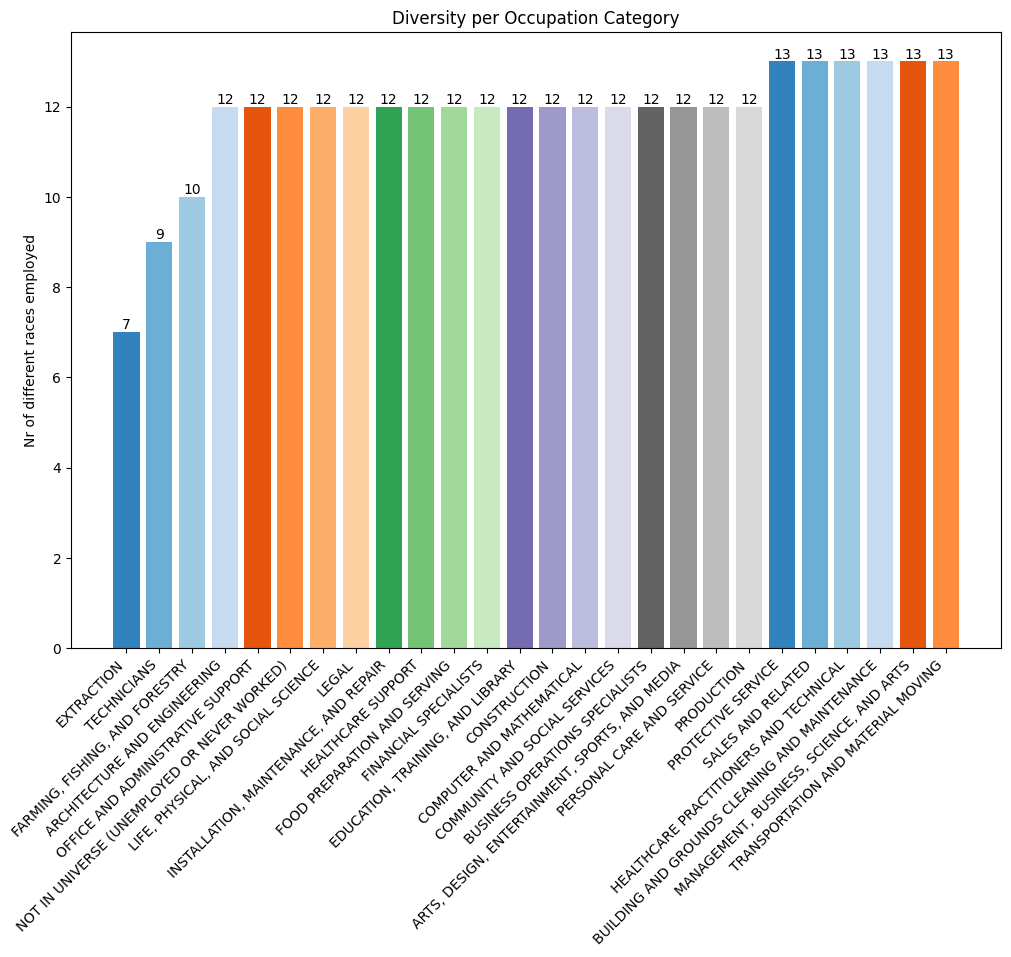

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
bar_container = ax.bar(diversity_df['occ_category'], diversity_df['nr_races'], color=plt.cm.tab20c.colors
        )

ax.set_title('Diversity per Occupation Category', y = 1)
ax.set(ylabel='Nr of different races employed')
ax.bar_label(bar_container, fmt='{:,.0f}')
ax.set_xticklabels(diversity_df['occ_category'], rotation = 45, ha='right')
plt.show()

### Plot
For each occupation category plot the amount of people per race working in that field. It can be observed that several categories are more diverse than others. 
* Art, Design, Entertainment Sports and Media is very diverse. But maybe this is because this cateory combines many subcategories.
* Extraction + military are least diverse. They both contain only few jobs (4 and 5)
* Food preperation and Serving + Healthcare are the most diverse categories.

Absolute numbers

C:\Users\jputz\AppData\Local\Temp\ipykernel_13112\3418571177.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = race_occ_df.groupby(['occ_category', 'race_title']).size().reset_index(name='count')
C:\Users\jputz\AppData\Local\Temp\ipykernel_13112\3418571177.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for occupation_category, group_df in grouped_df.groupby('occ_category'):
C:\Users\jputz\AppData\Local\Temp\ipykernel_13112\3418571177.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ti

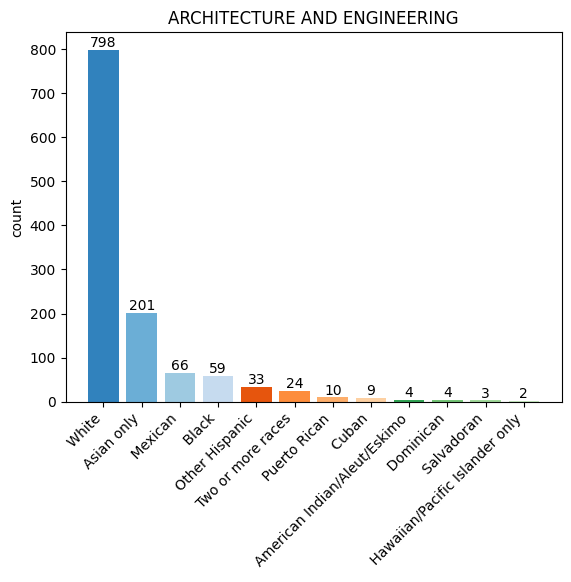

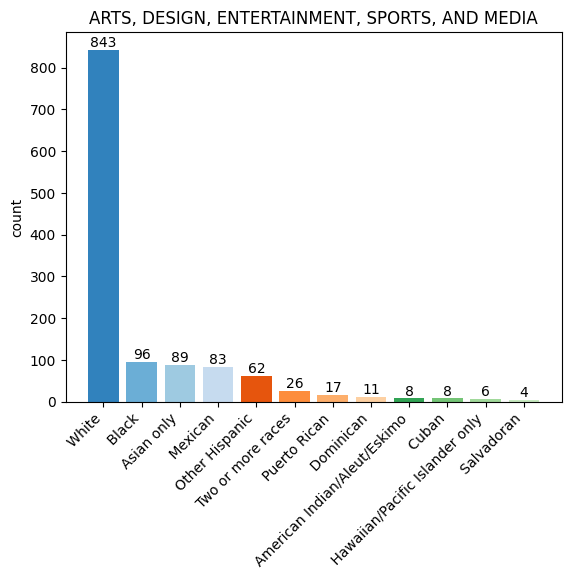

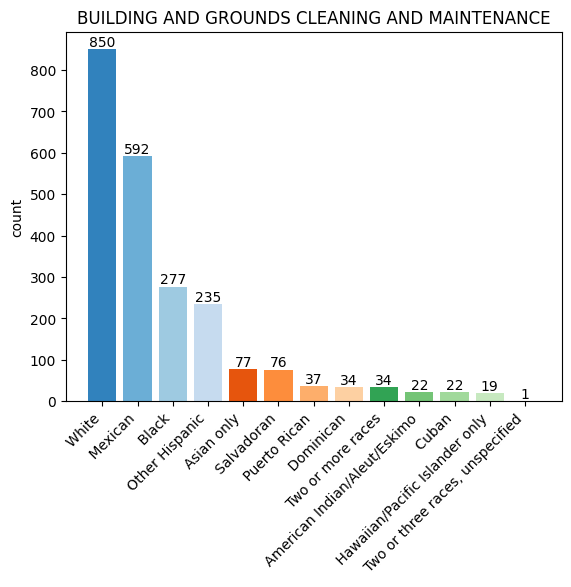

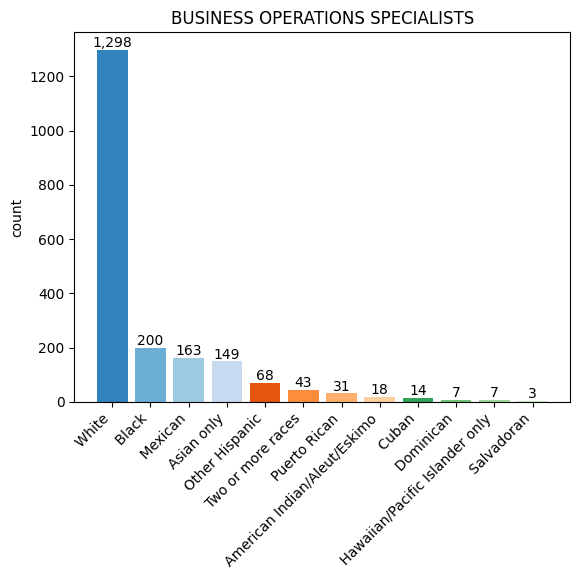

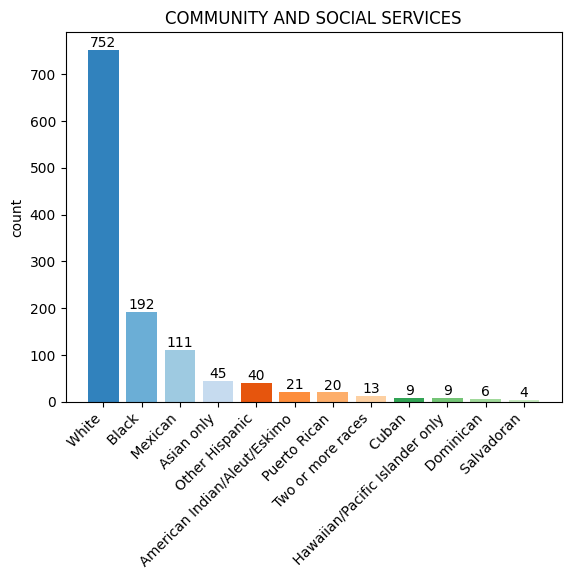

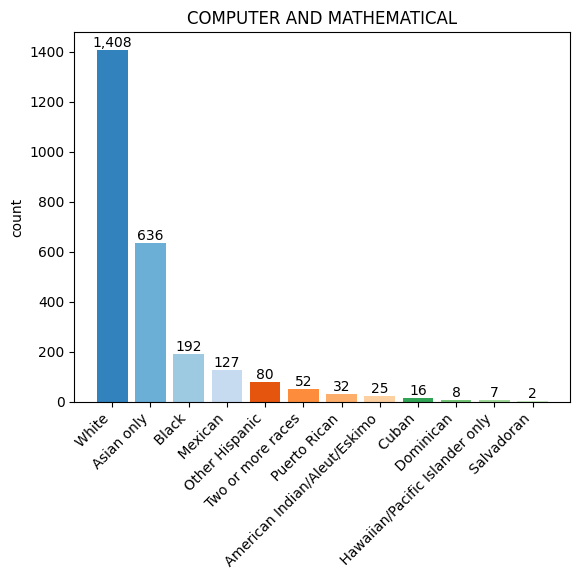

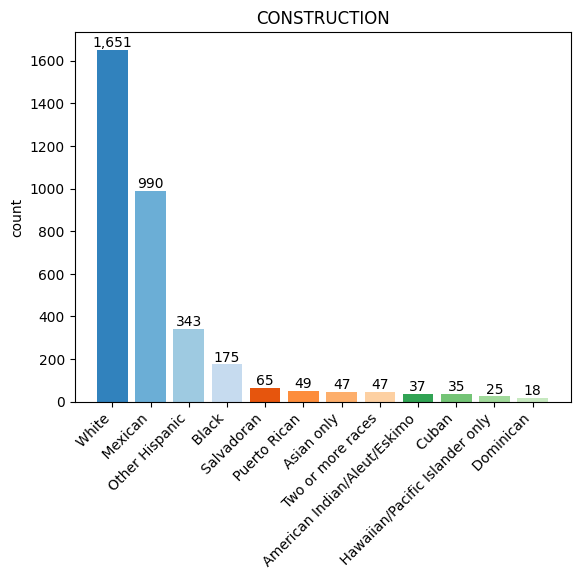

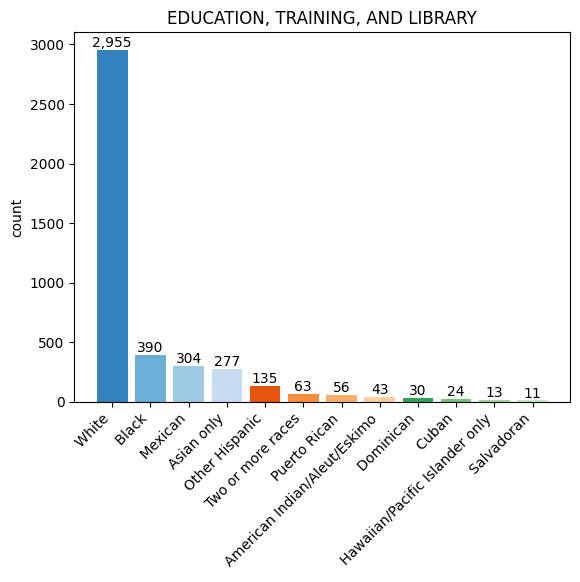

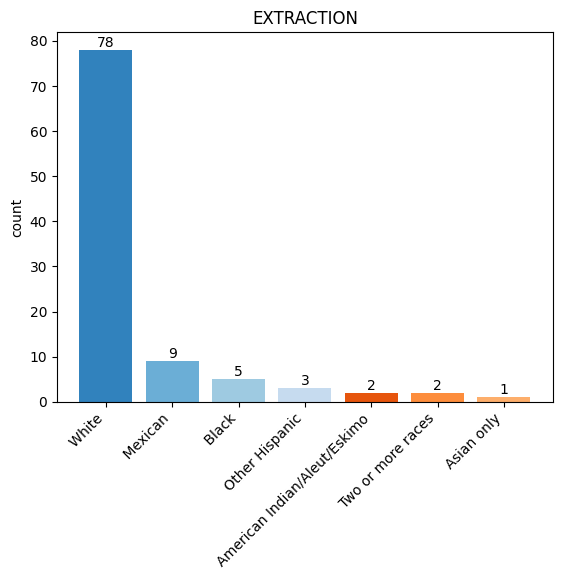

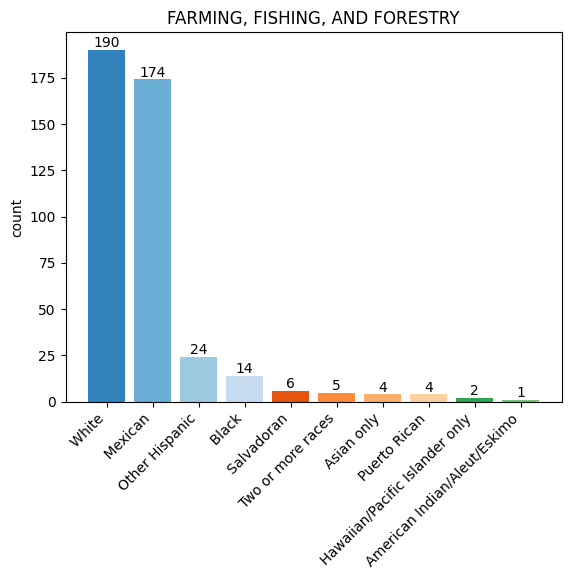

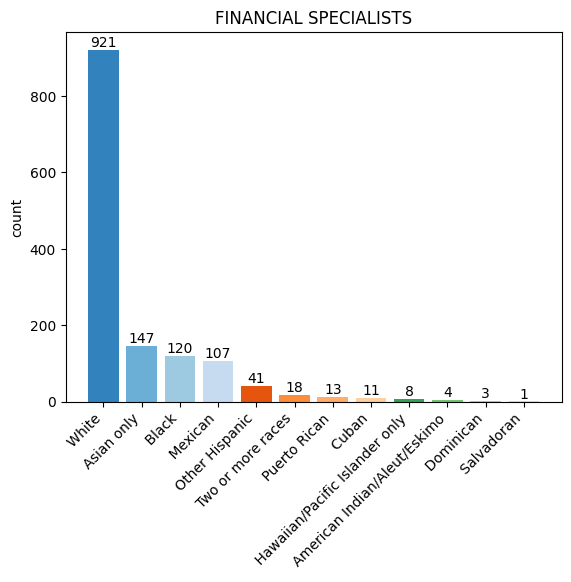

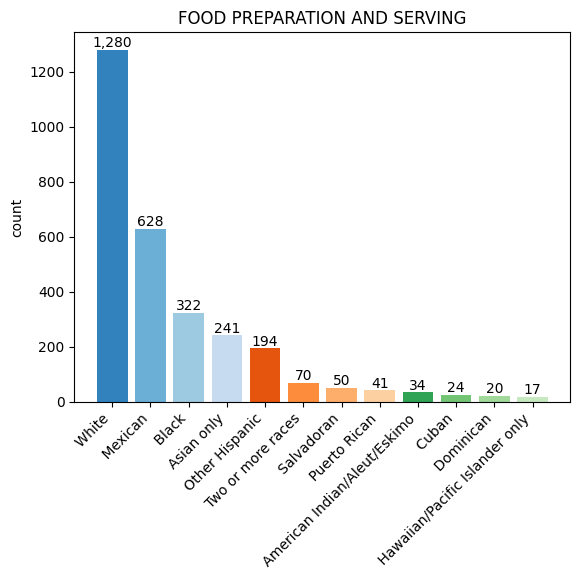

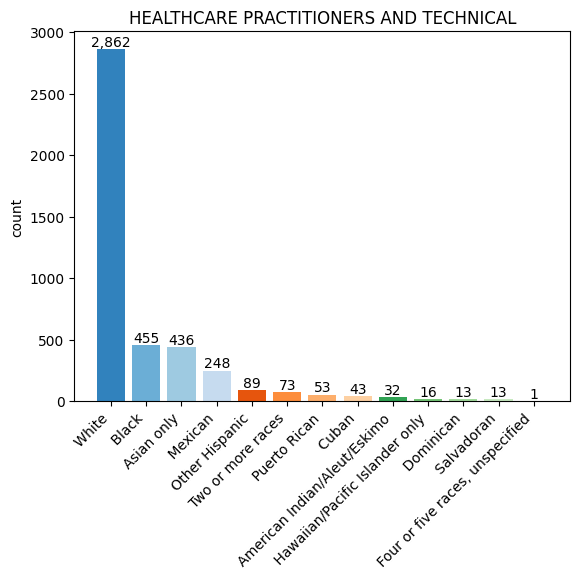

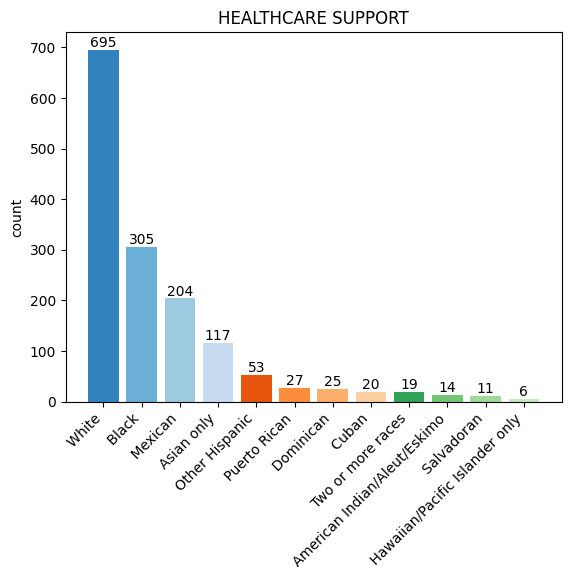

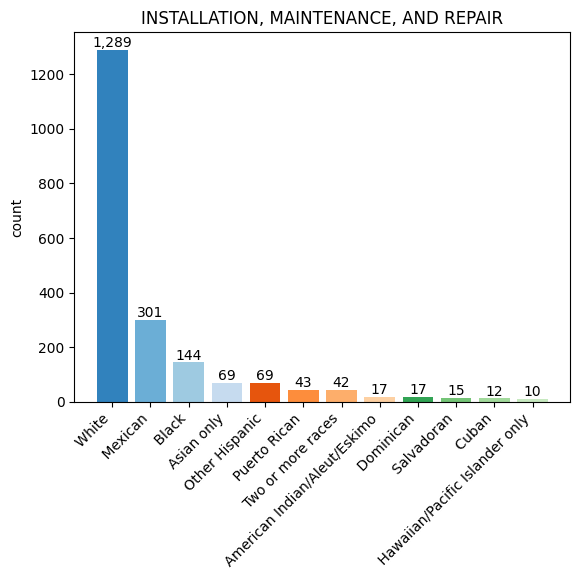

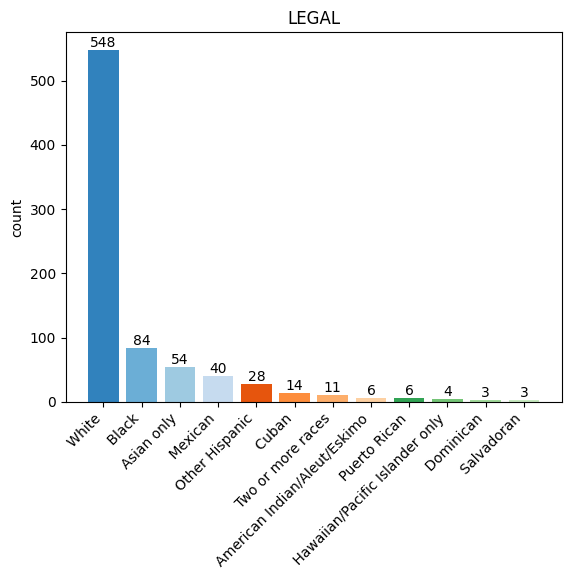

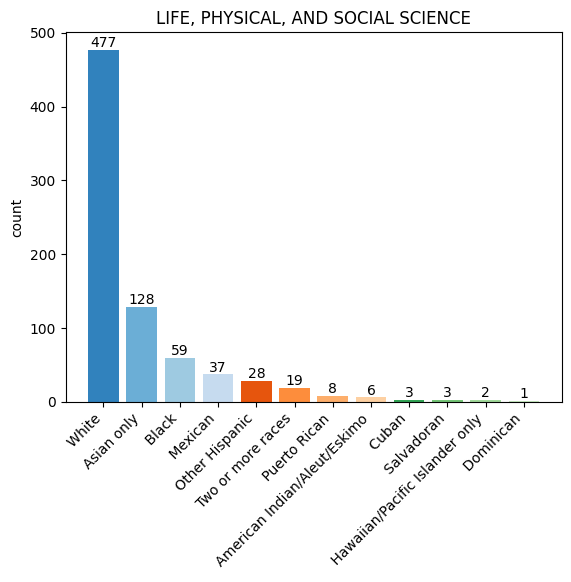

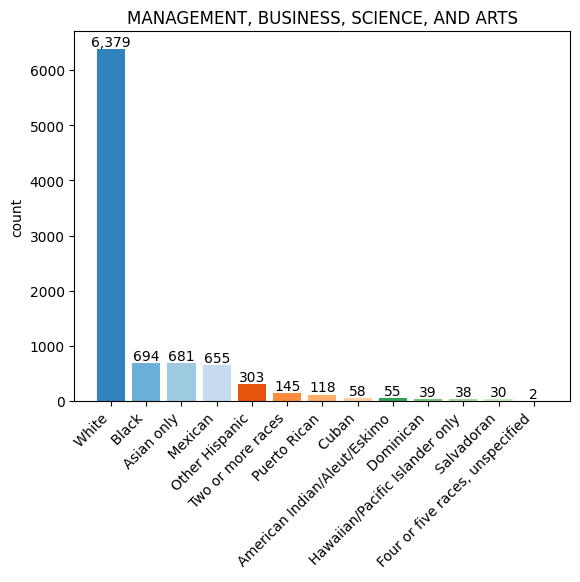

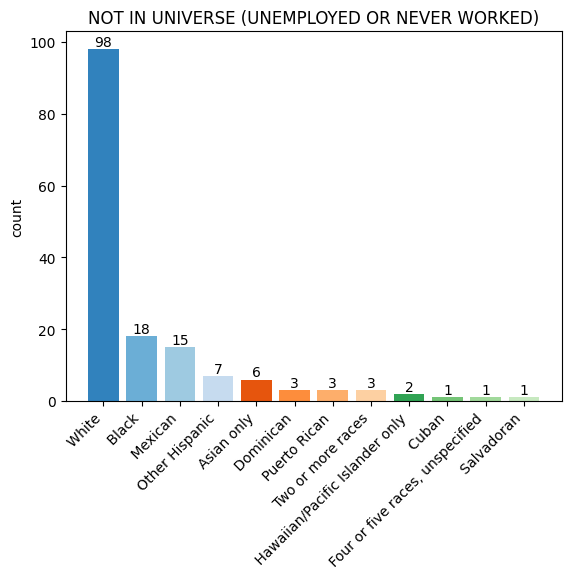

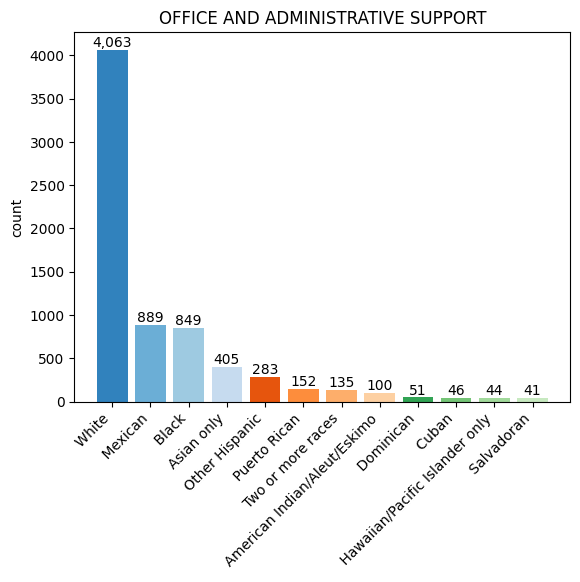

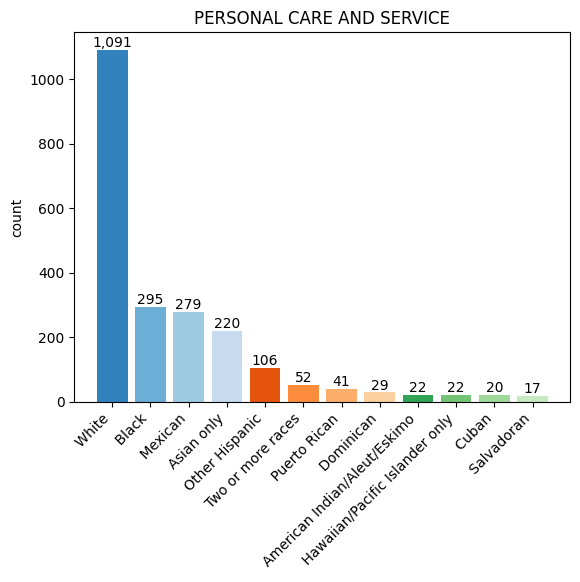

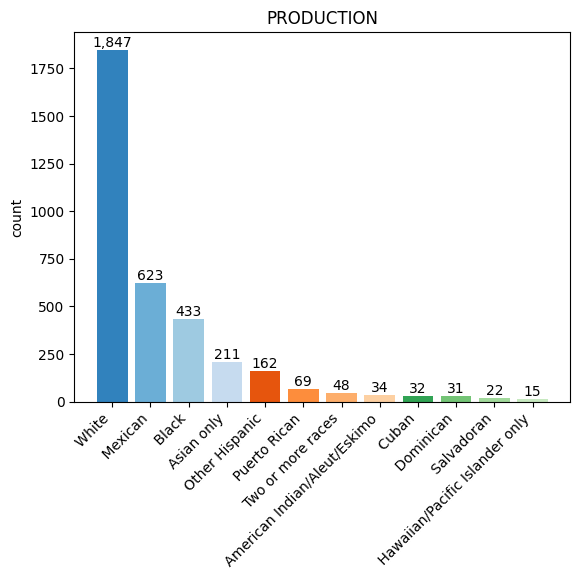

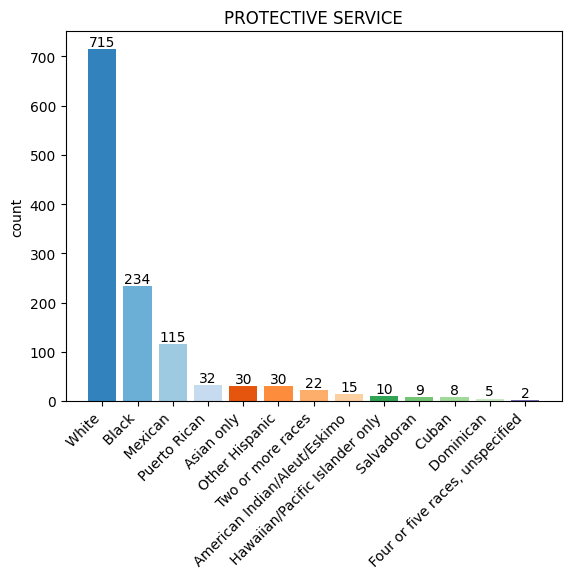

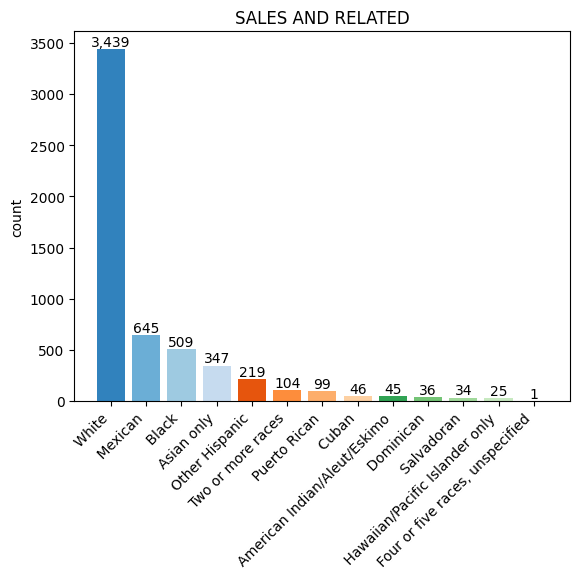

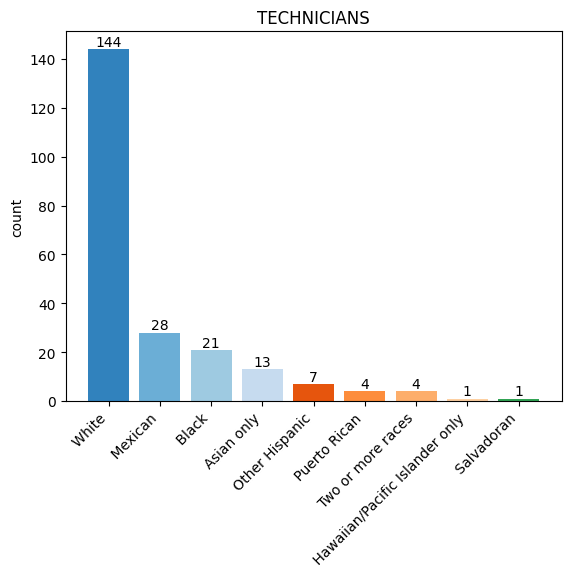

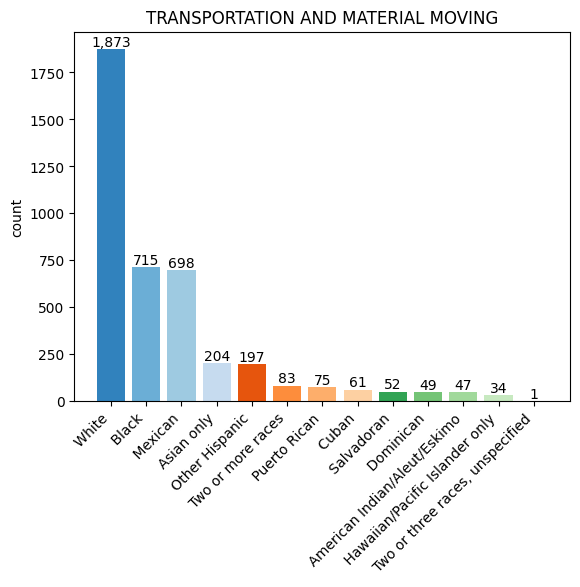

In [22]:
grouped_df = race_occ_df.groupby(['occ_category', 'race_title']).size().reset_index(name='count')
for occupation_category, group_df in grouped_df.groupby('occ_category'):
    # Pivot the DataFrame to have 'race_title' as columns and 'count' as values
    pivot_df = group_df.pivot(index='occ_category', columns='race_title', values='count').fillna(0)
    # only select those races which are present in the category
    pivot_df = pivot_df.loc[:, (pivot_df != 0).any(axis=0)]

    pivot_df = pivot_df.sort_values(by = f'{occupation_category}', axis = 1, ascending = False) 

    array = pivot_df.to_numpy()
    titles = list(pivot_df.columns)

    cmap = plt.cm.tab20c
    colors = cmap(np.arange(len(titles)) % cmap.N)

    fig, ax = plt.subplots()
    bar_container = ax.bar(titles, array[0], color = colors)
    ax.set(ylabel='count', title=f'{occupation_category}')
    ax.bar_label(bar_container, fmt='{:,.0f}')
    ax.set_xticklabels(titles, rotation = 45, ha='right')

Percentage <br>
Percentage of people belonging to race xy that work in occupation category z.

C:\Users\jputz\AppData\Local\Temp\ipykernel_13112\2002556395.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = race_occ_df.groupby(['occ_category', 'race_title']).size().reset_index(name='count')
C:\Users\jputz\AppData\Local\Temp\ipykernel_13112\2002556395.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for occupation_category, group_df in grouped_df.groupby('occ_category'):
C:\Users\jputz\AppData\Local\Temp\ipykernel_13112\2002556395.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ti

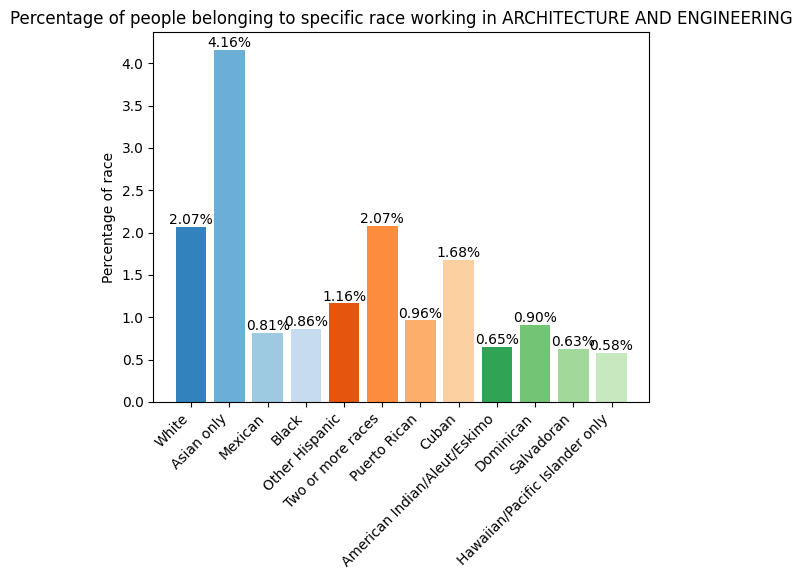

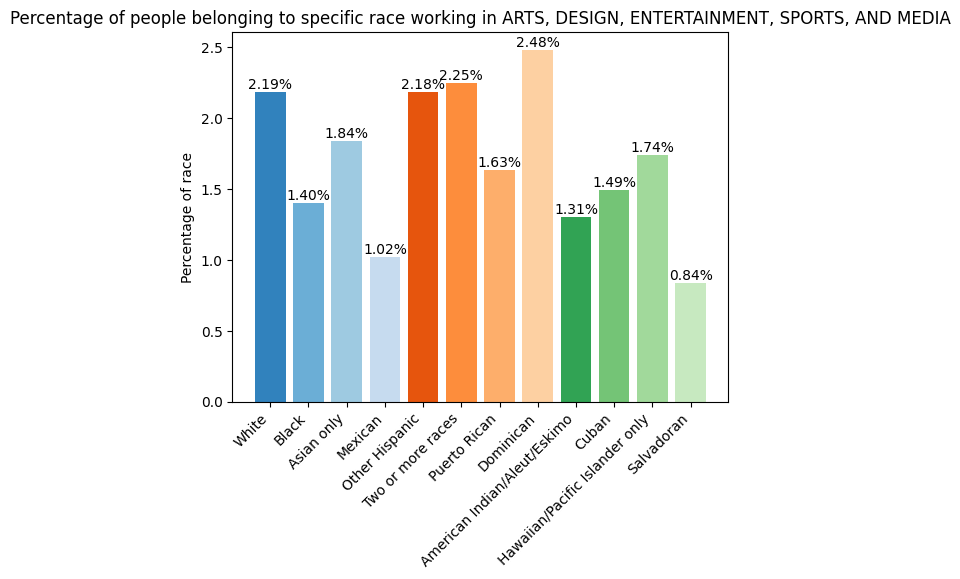

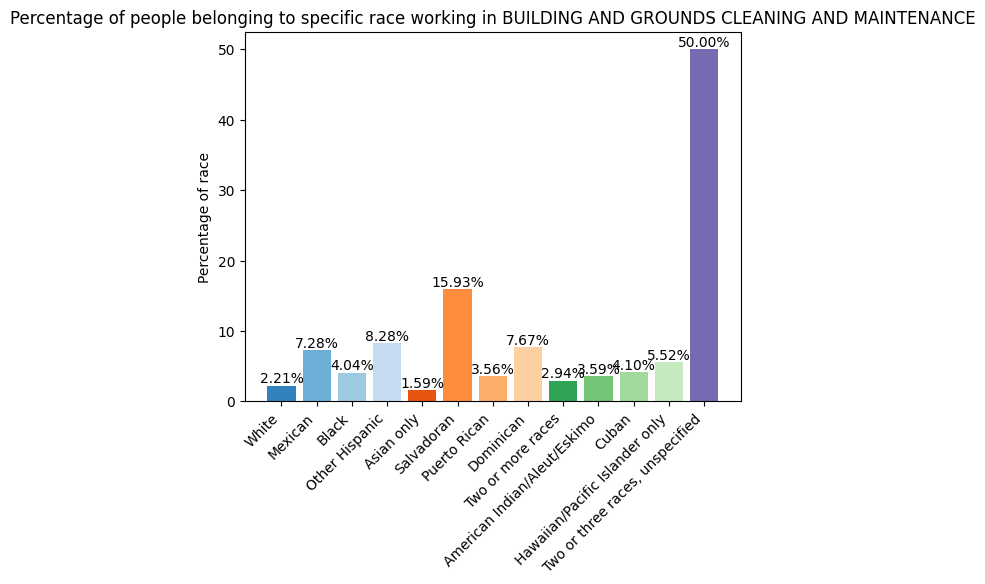

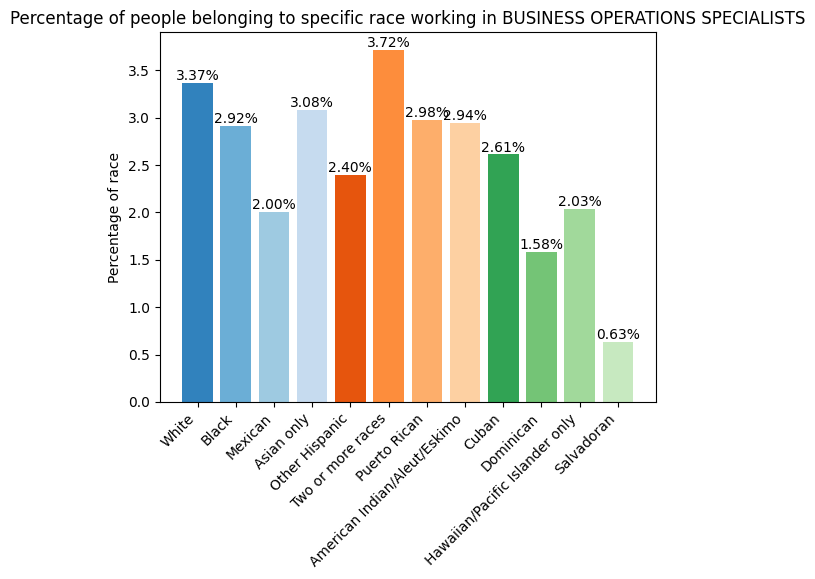

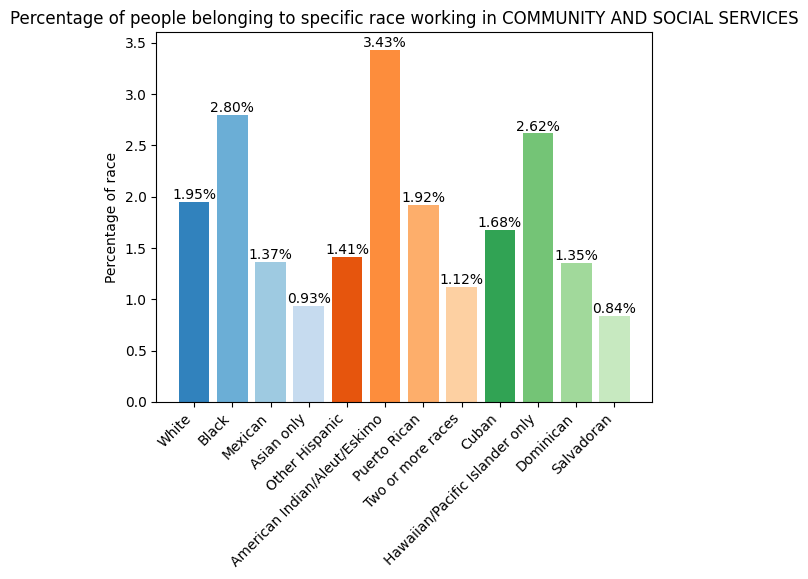

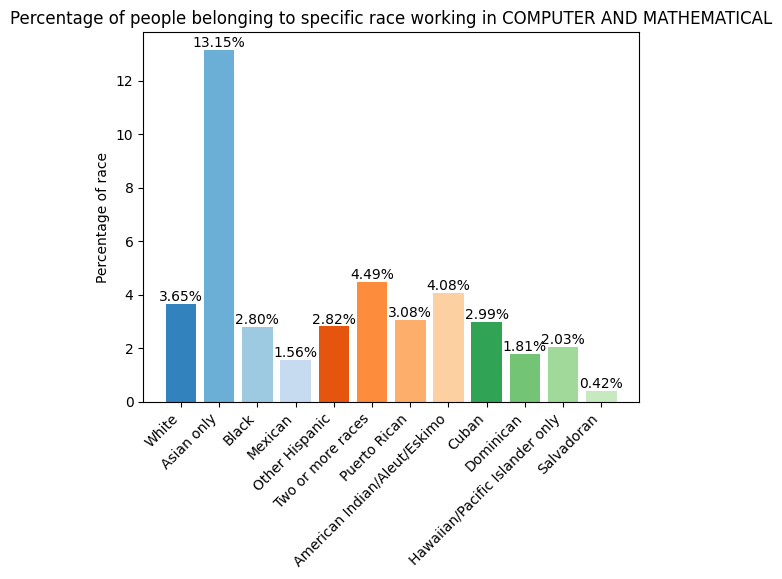

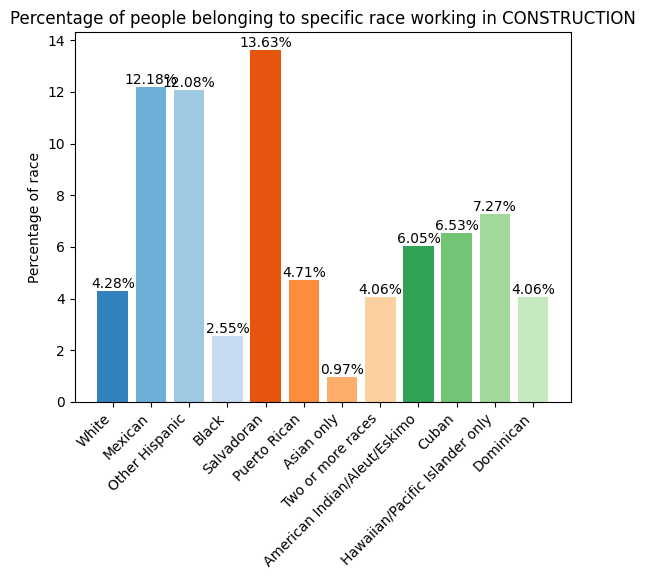

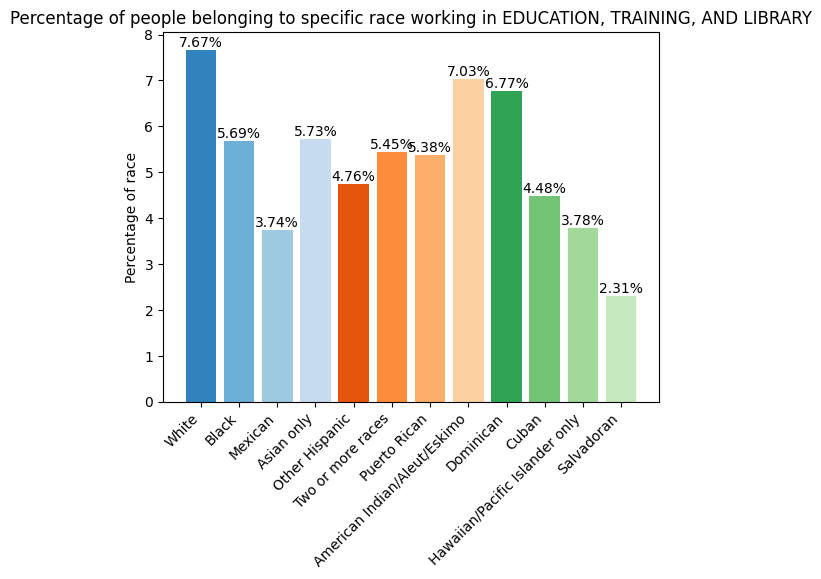

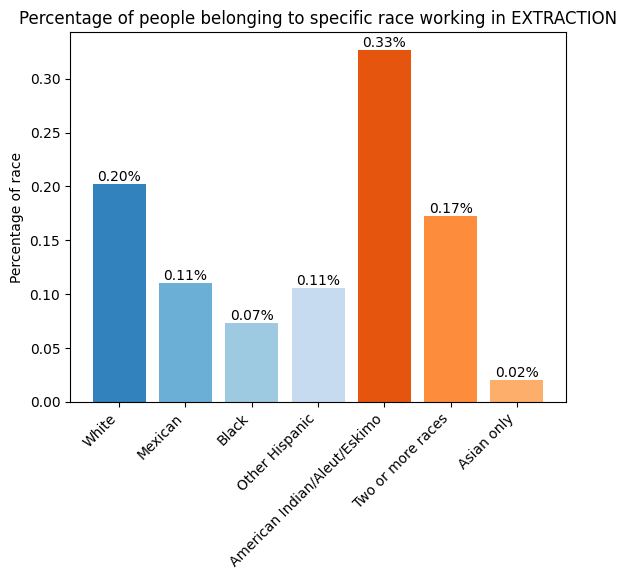

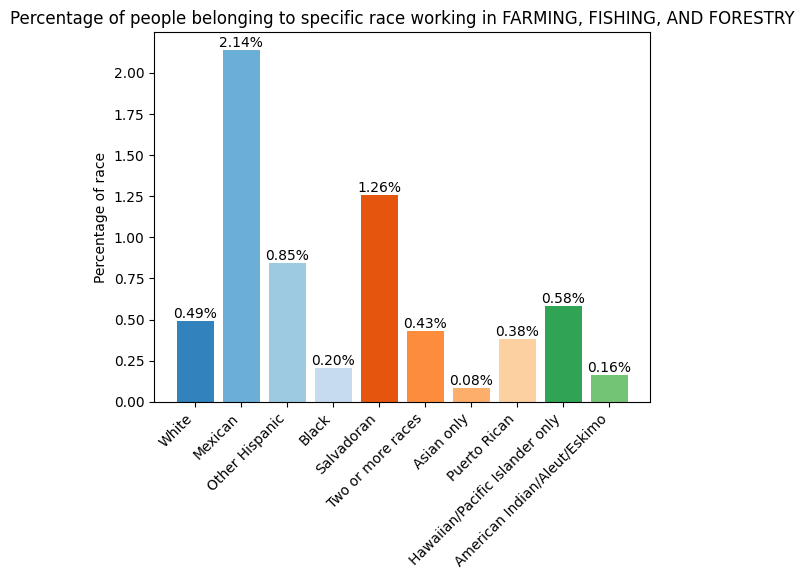

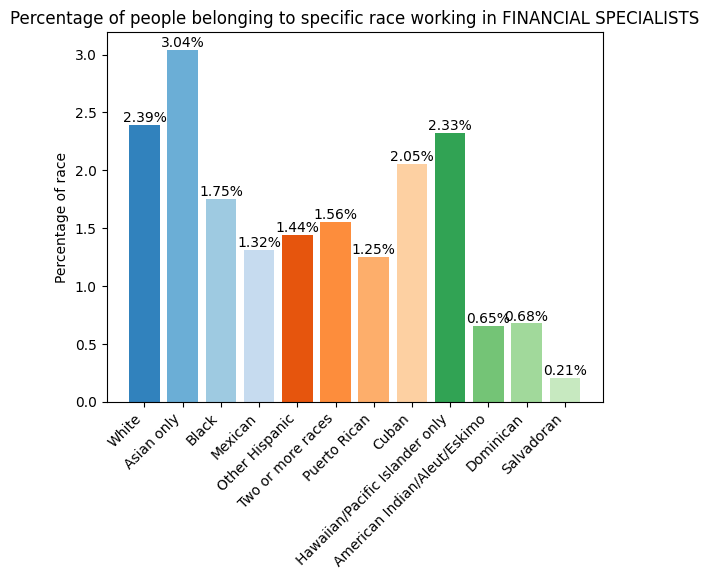

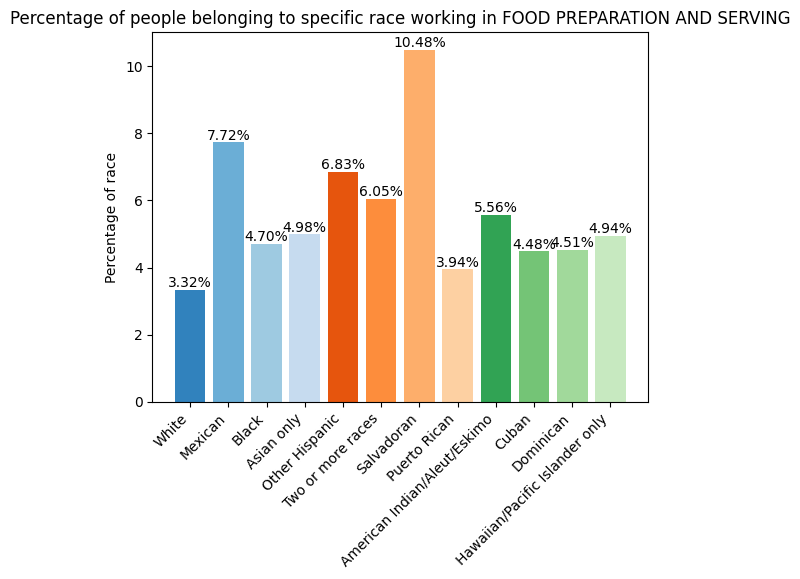

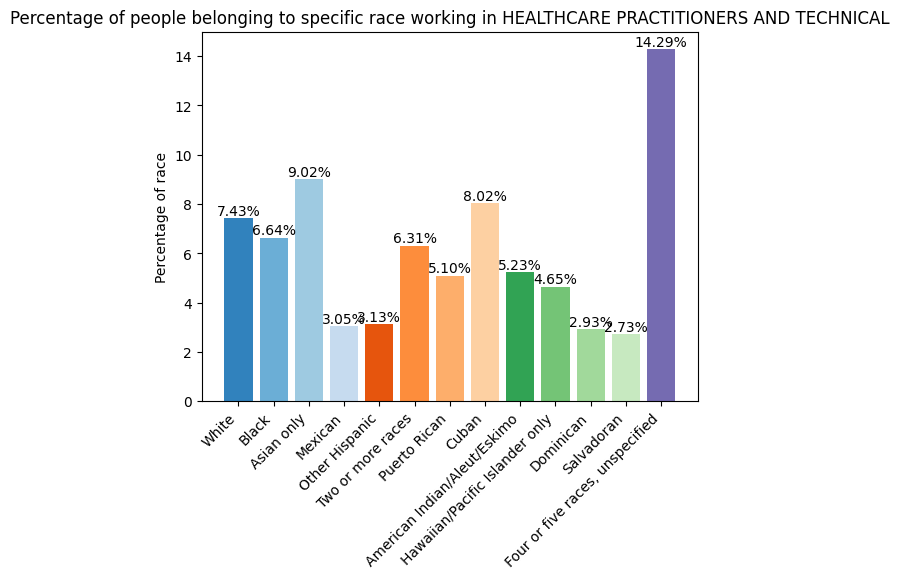

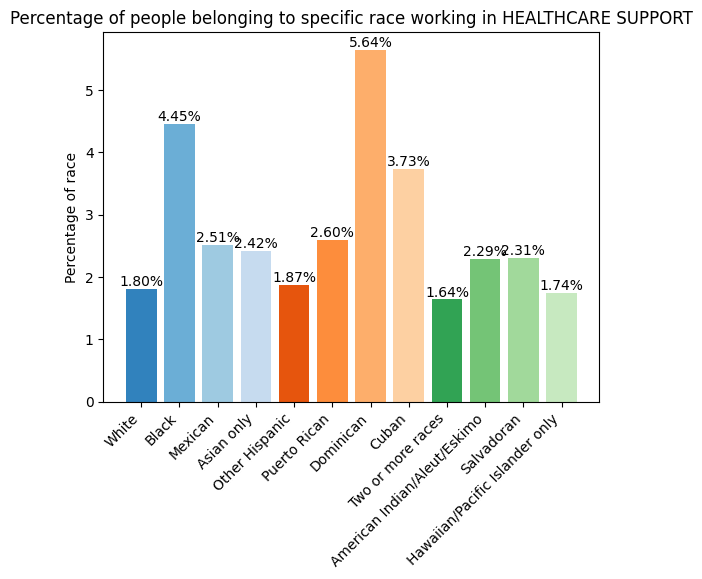

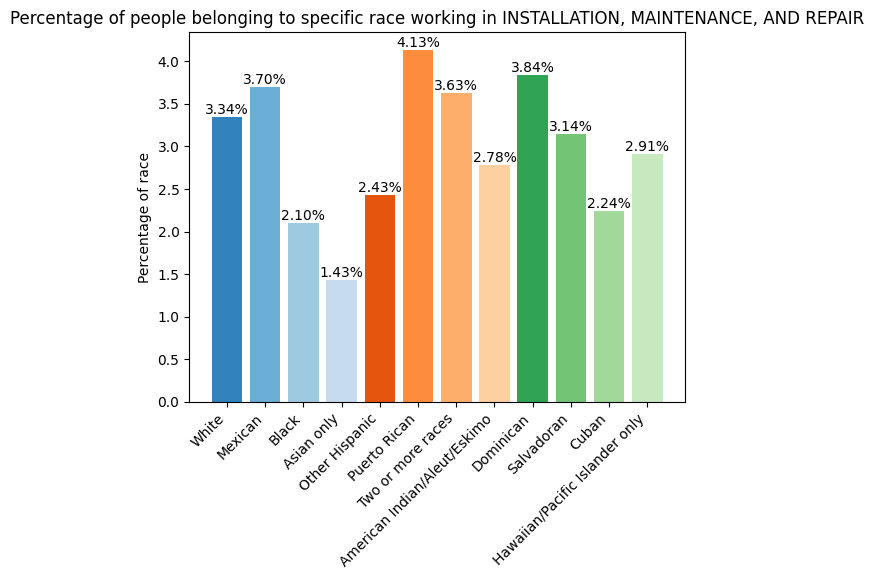

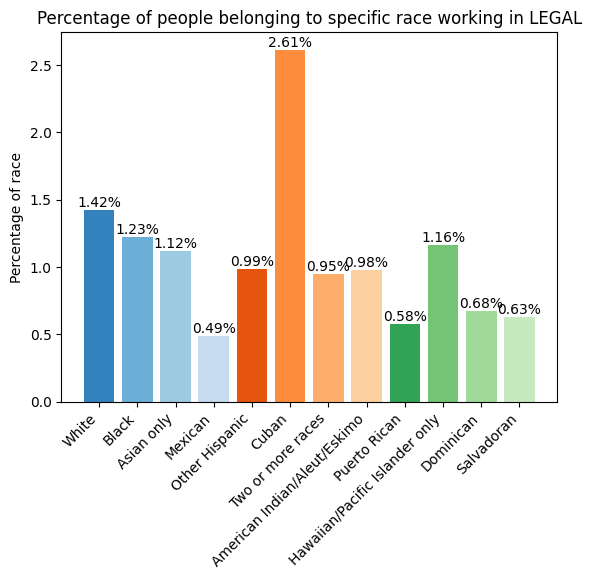

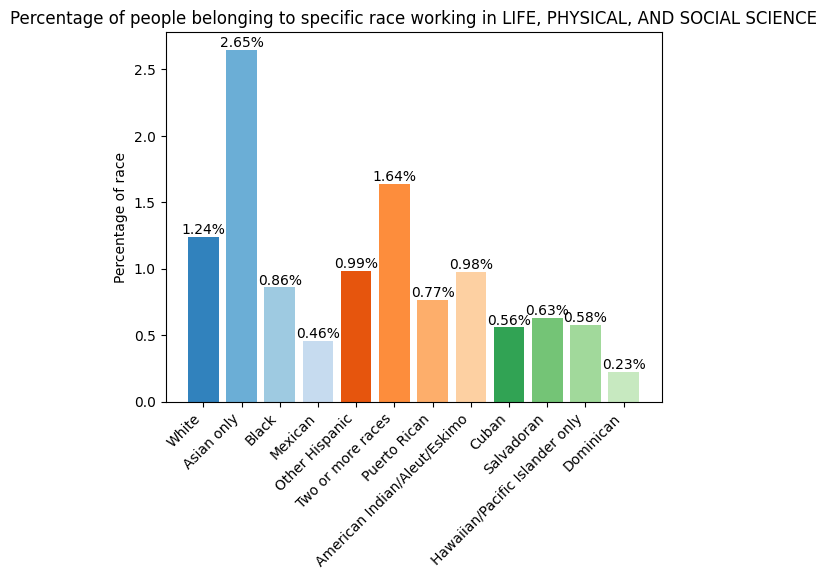

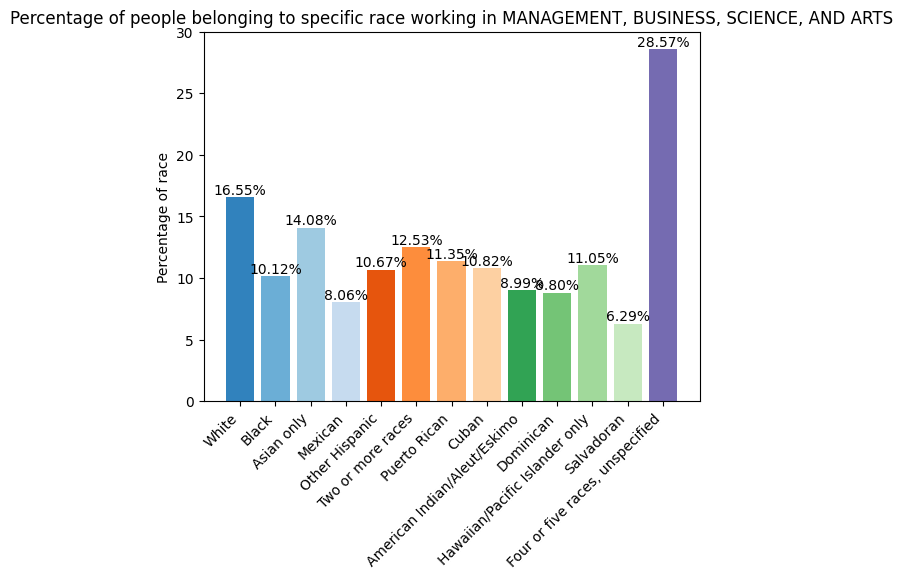

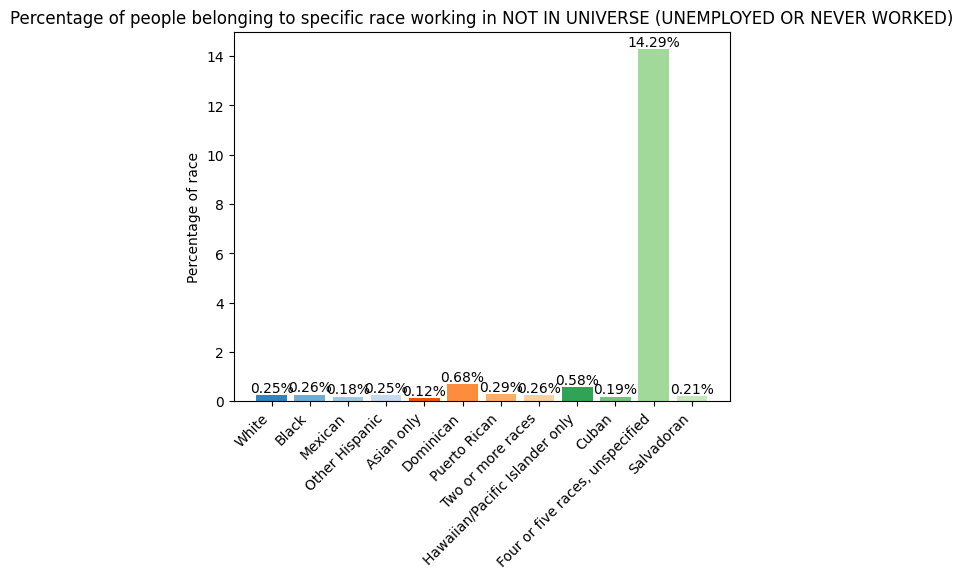

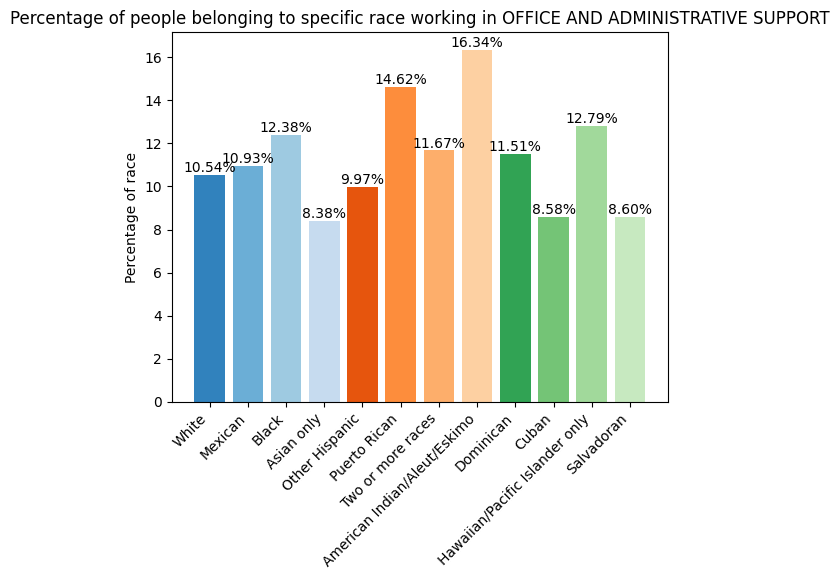

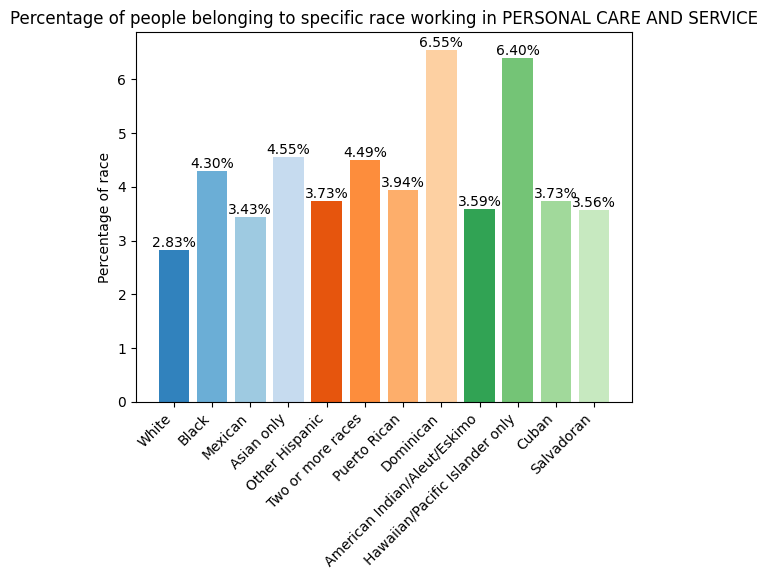

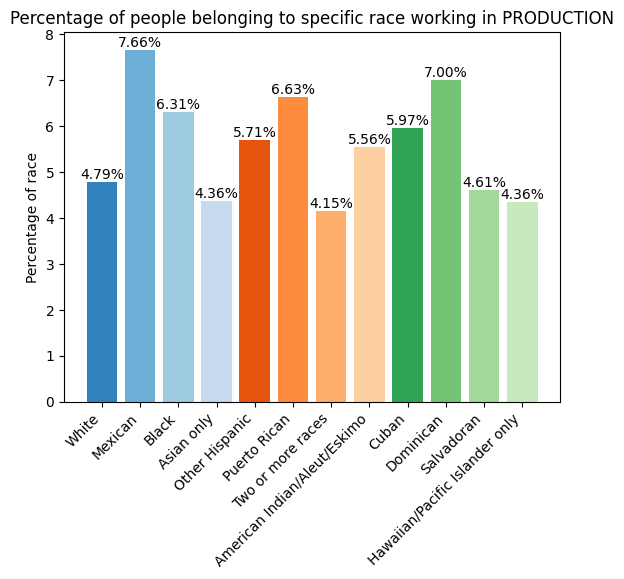

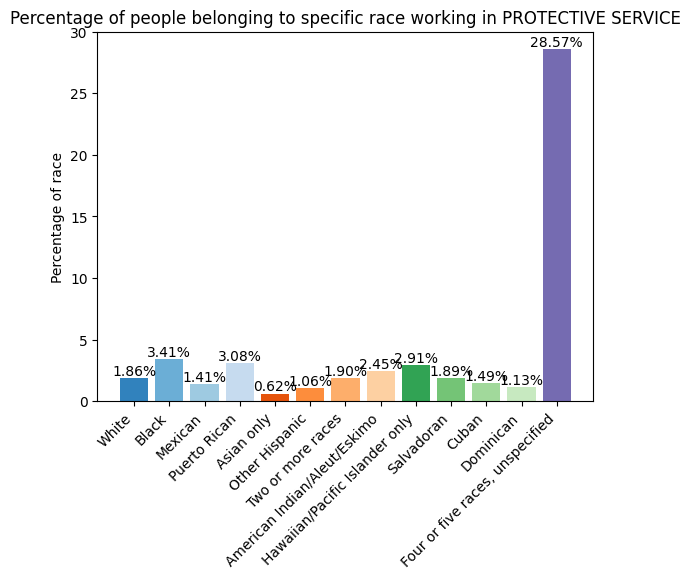

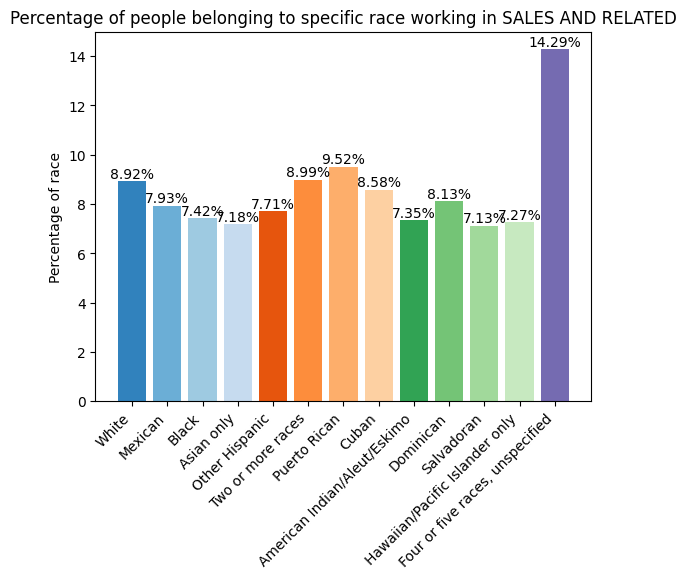

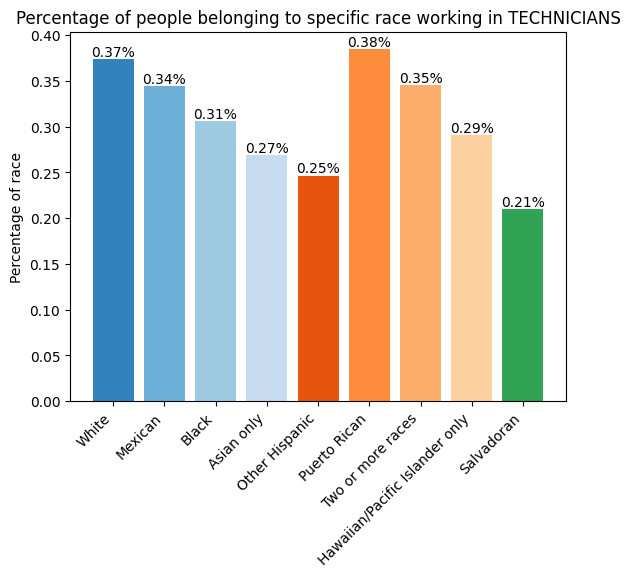

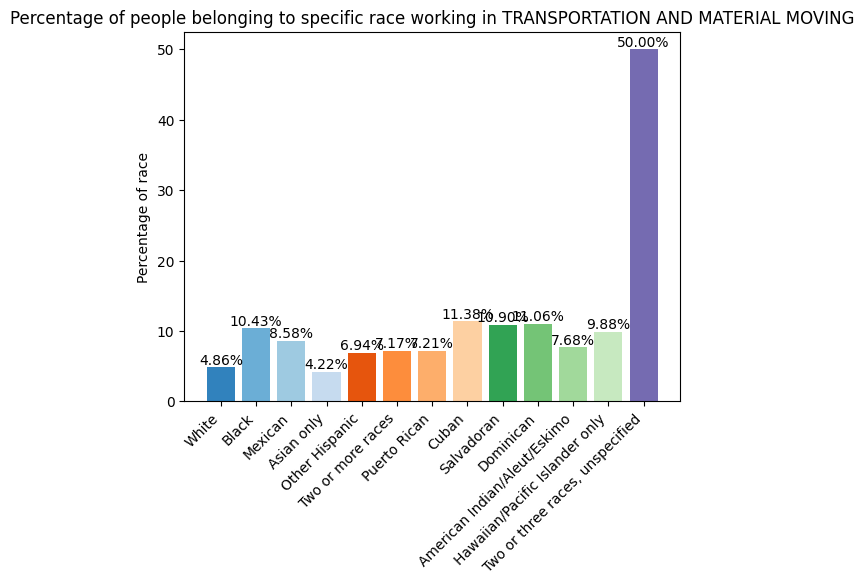

In [23]:
grouped_df = race_occ_df.groupby(['occ_category', 'race_title']).size().reset_index(name='count')
for occupation_category, group_df in grouped_df.groupby('occ_category'):
    # Pivot the DataFrame to have 'race_title' as columns and 'count' as values
    pivot_df = group_df.pivot(index='occ_category', columns='race_title', values='count').fillna(0)
    # only select those races which are present in the category
    pivot_df = pivot_df.loc[:, (pivot_df != 0).any(axis=0)]

    pivot_df = pivot_df.sort_values(by = f'{occupation_category}', axis = 1, ascending = False) 

    array = pivot_df.to_numpy()
    array = array[0]
    titles = list(pivot_df.columns.str.strip())

    current_title = 0
    relative_array = []
    for count in array:
        relative_array.append(100 / race_counts[race_counts['race_title'].str.strip() == titles[current_title]]['total_counts'].item() * count)
        current_title += 1

    cmap = plt.cm.tab20c
    colors = cmap(np.arange(len(titles)) % cmap.N)

    fig, ax = plt.subplots()
    bar_container = ax.bar(titles, relative_array, color = colors)
    ax.set(ylabel='Percentage of race', title=f'Percentage of people belonging to specific race working in {occupation_category}')
    ax.bar_label(bar_container, fmt=lambda x: f'{x:.2f}%')
    ax.set_xticklabels(titles, rotation = 45, ha='right')

Weight (ASECWT)

C:\Users\jputz\AppData\Local\Temp\ipykernel_13112\1031991654.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = race_occ_df.groupby(['occ_category', 'race_title'])['ASECWT'].sum().reset_index()
C:\Users\jputz\AppData\Local\Temp\ipykernel_13112\1031991654.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for occupation_category, group_df in grouped_df.groupby('occ_category'):
C:\Users\jputz\AppData\Local\Temp\ipykernel_13112\1031991654.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(title

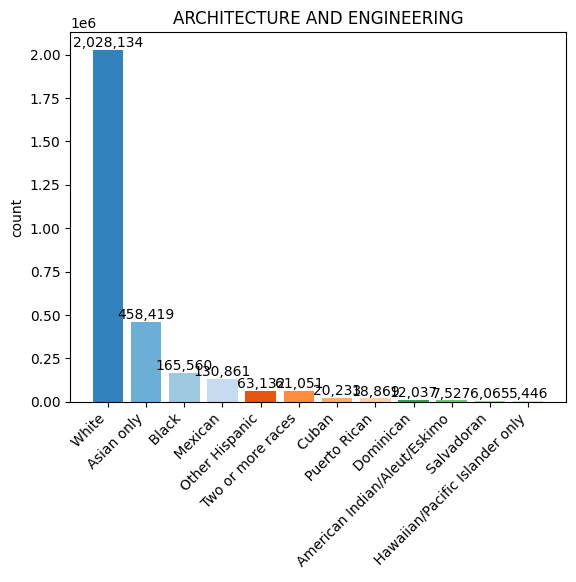

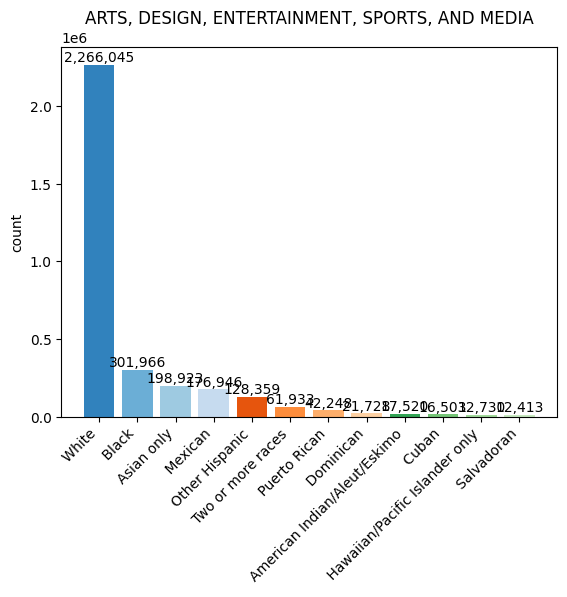

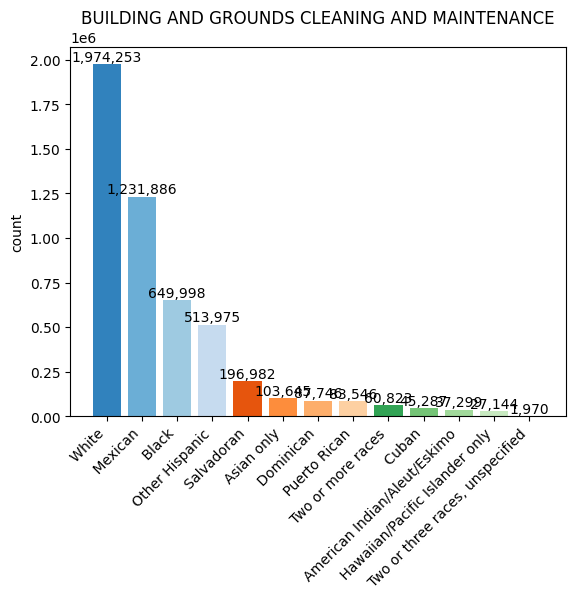

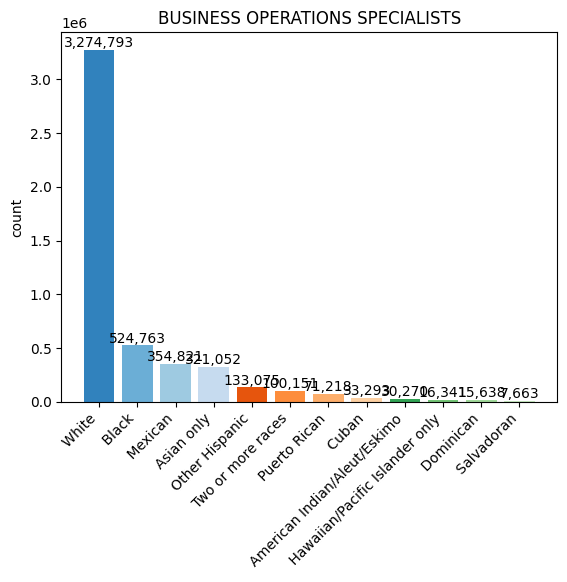

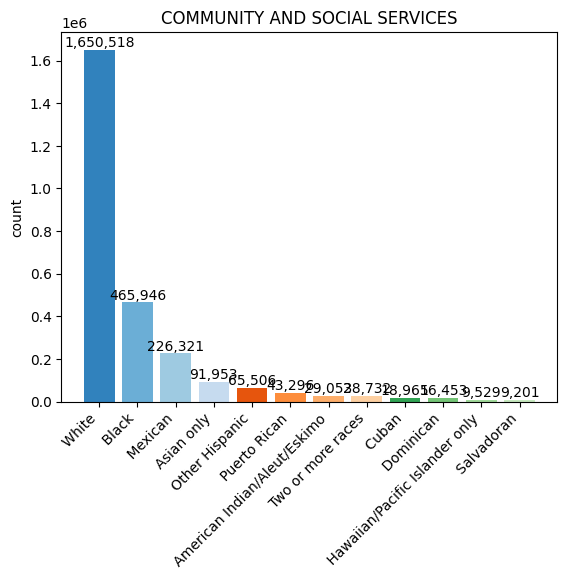

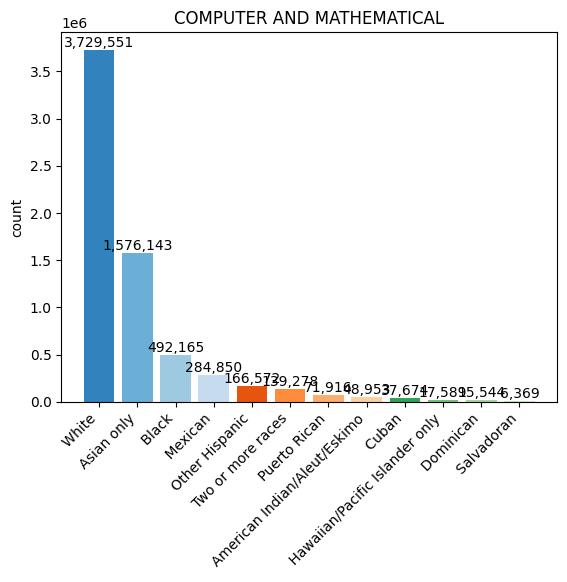

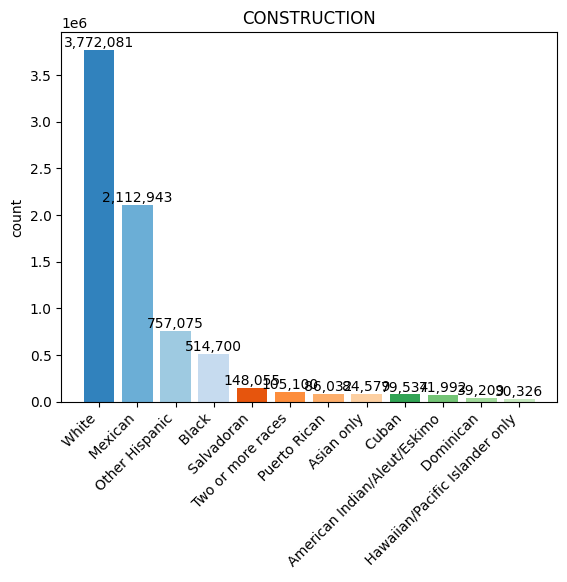

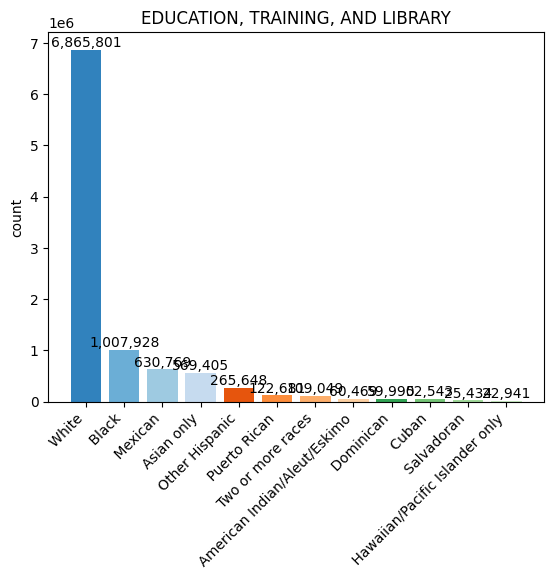

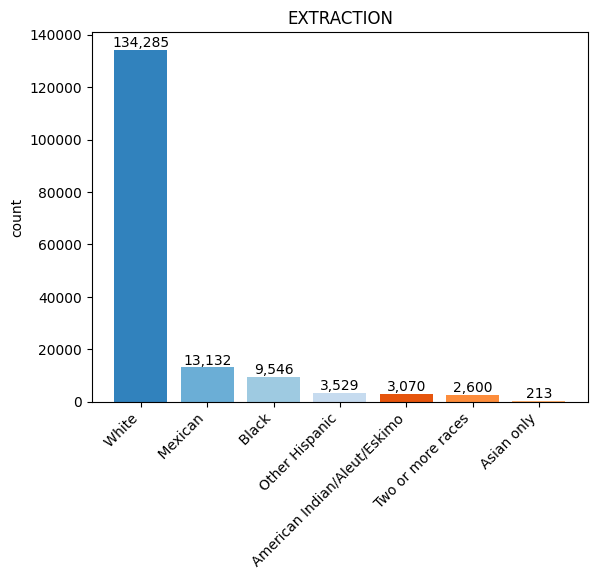

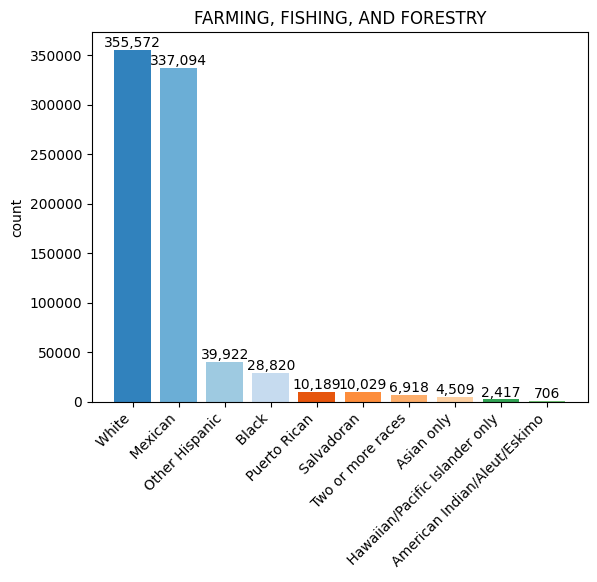

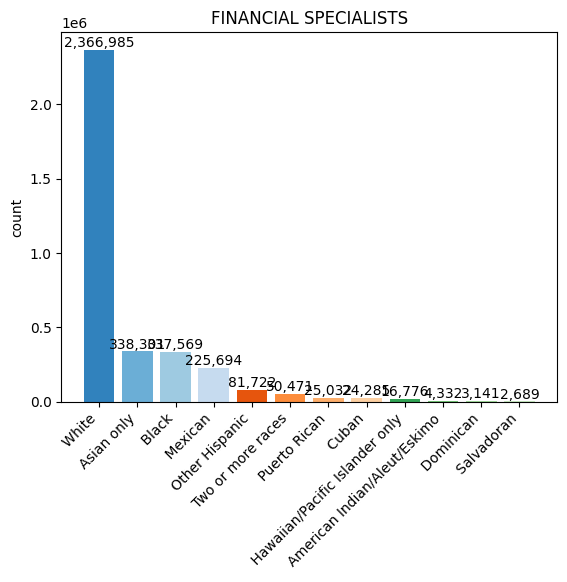

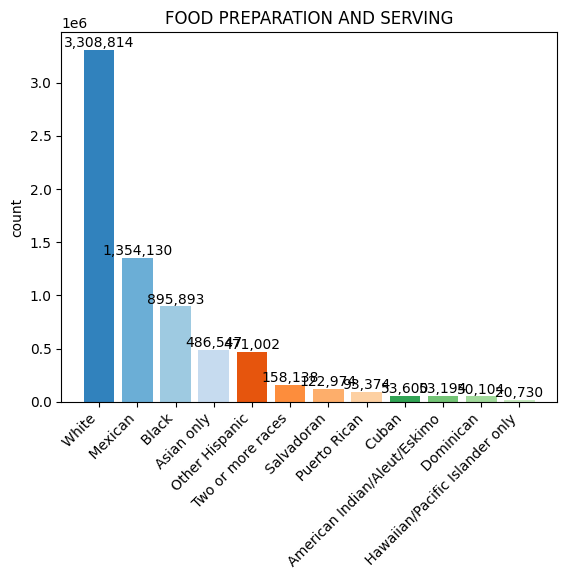

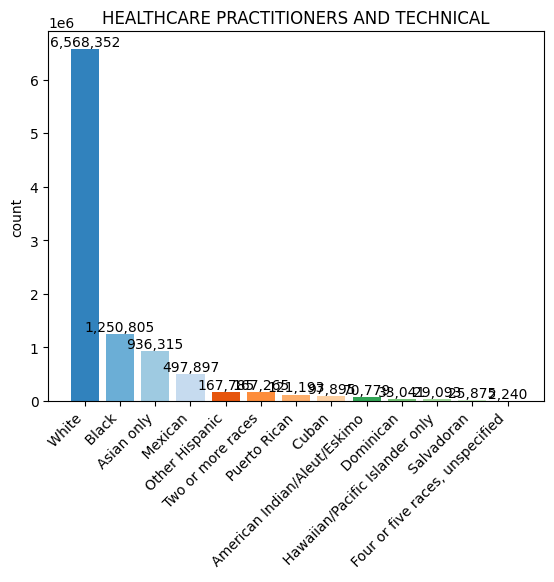

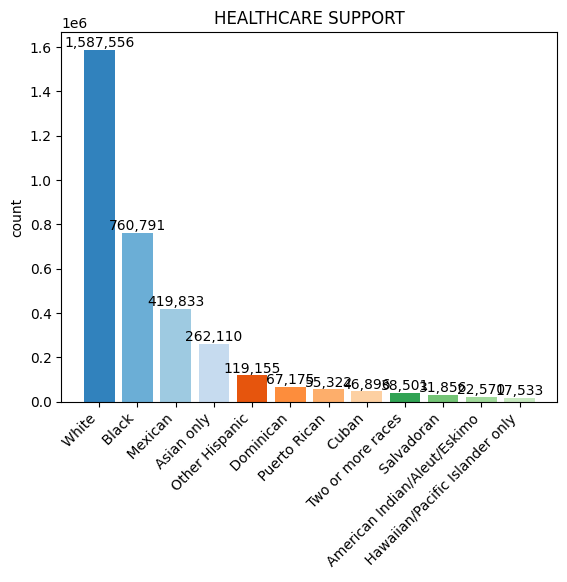

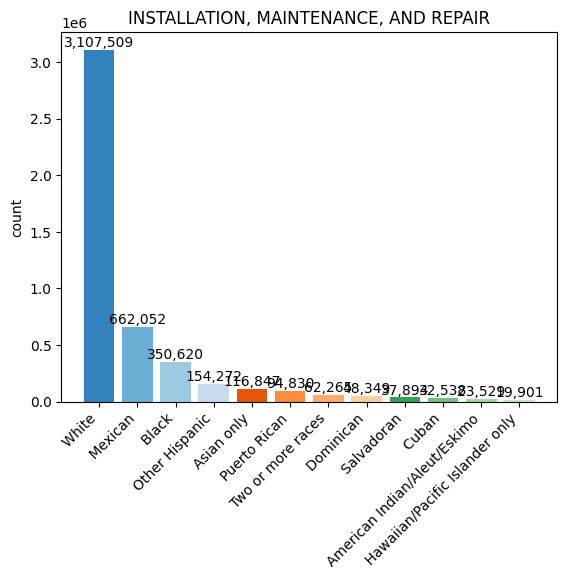

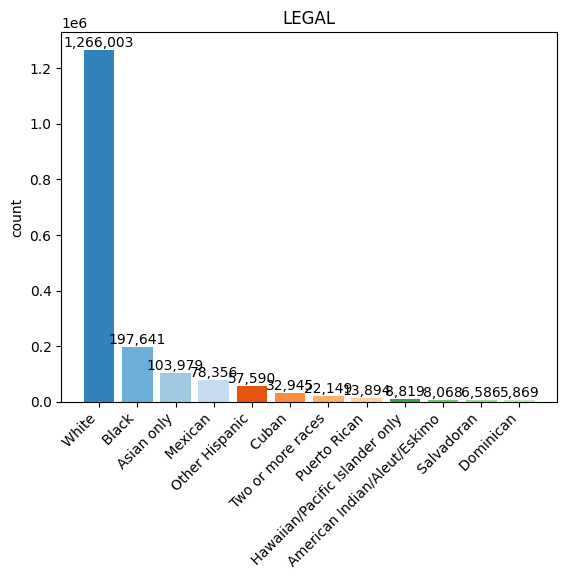

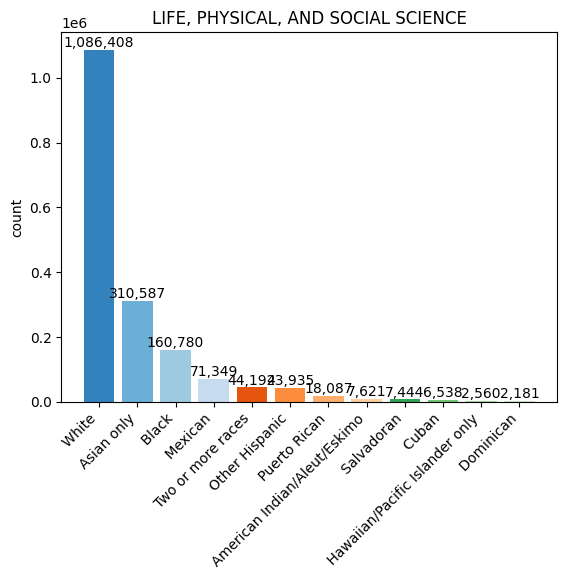

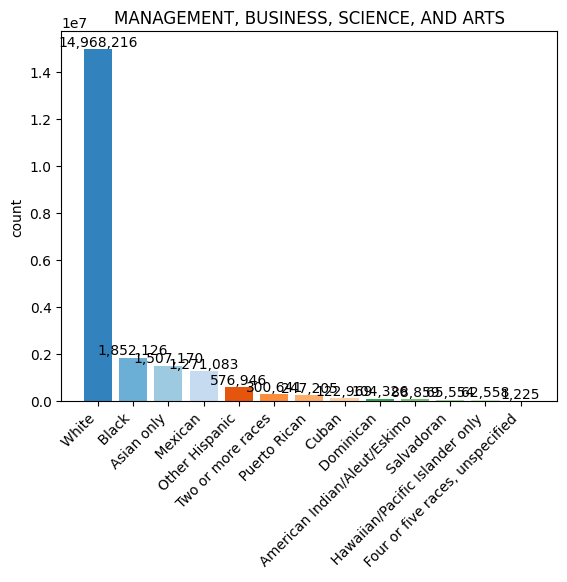

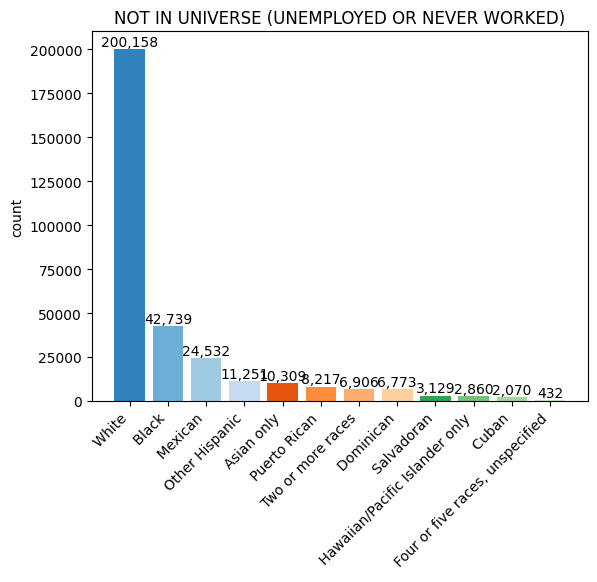

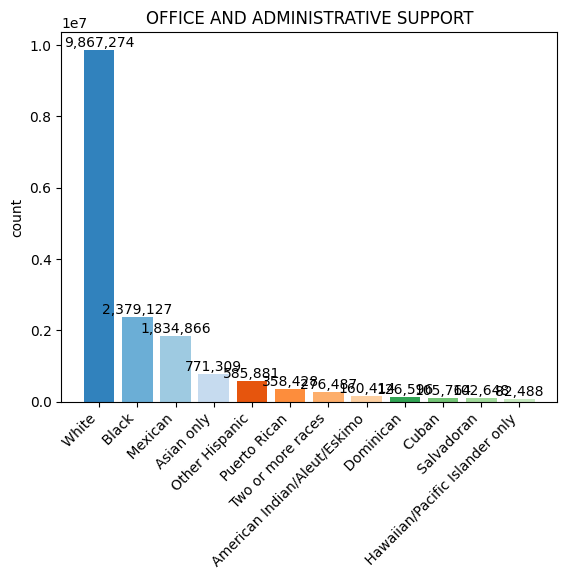

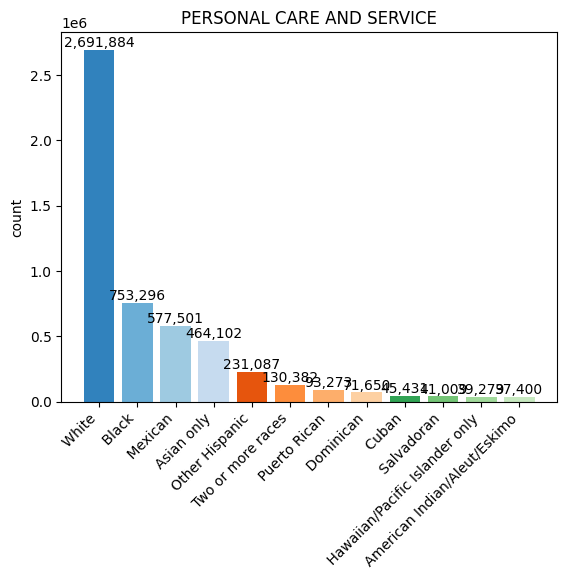

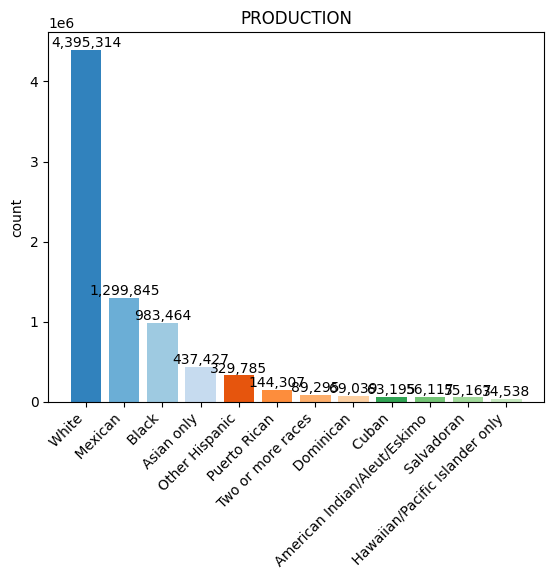

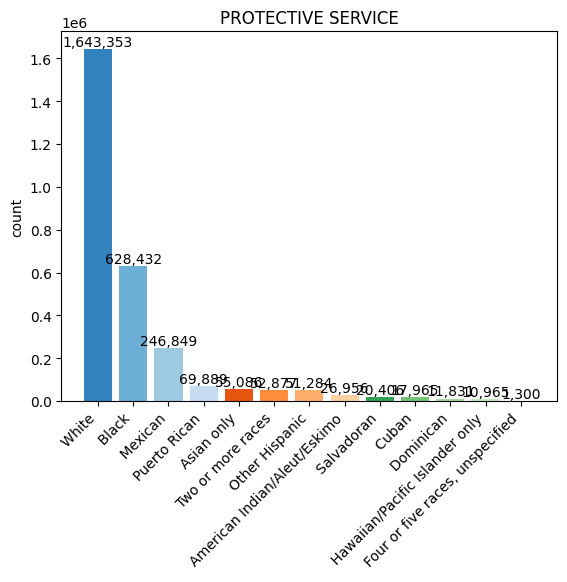

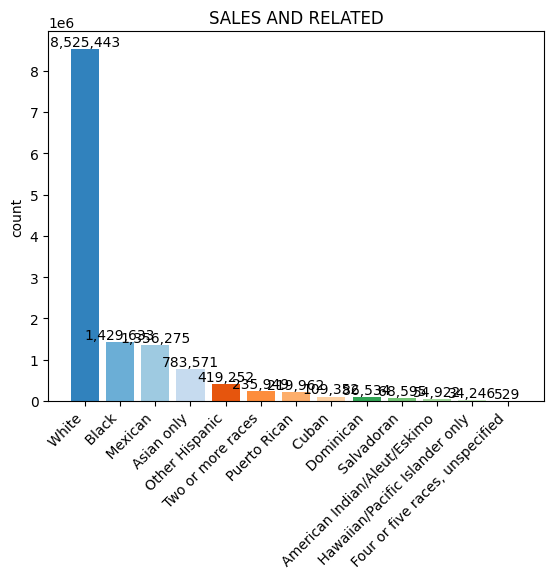

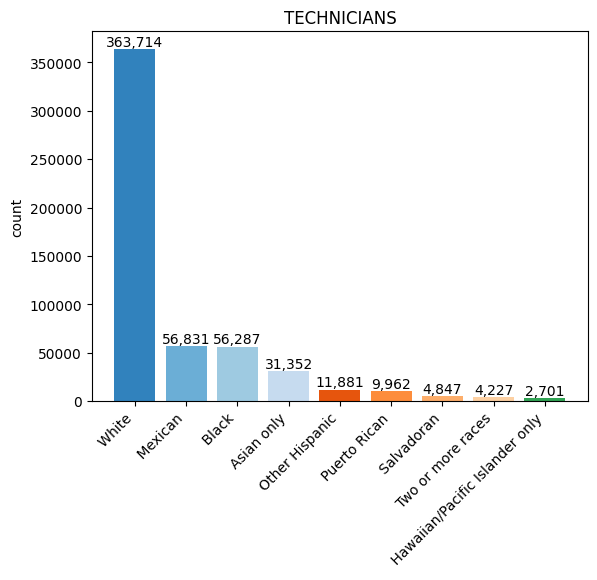

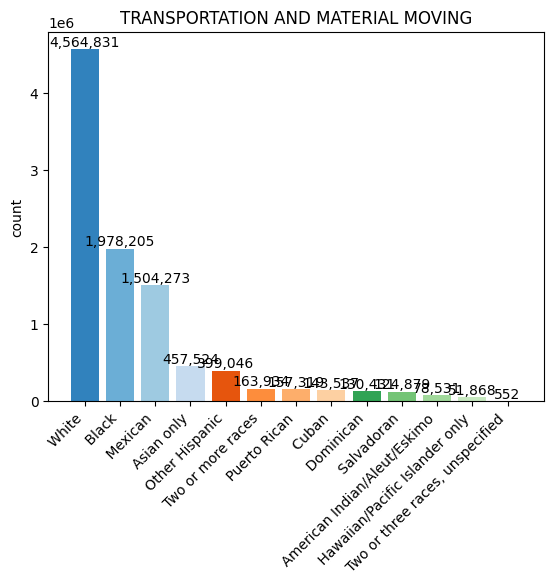

In [24]:
grouped_df = race_occ_df.groupby(['occ_category', 'race_title'])['ASECWT'].sum().reset_index()
for occupation_category, group_df in grouped_df.groupby('occ_category'):
    # Pivot the DataFrame to have 'race_title' as columns and 'count' as values
    pivot_df = group_df.pivot(index='occ_category', columns='race_title', values='ASECWT').fillna(0)
    # only select those races which are present in the category
    pivot_df = pivot_df.loc[:, (pivot_df != 0).any(axis=0)]
    
    pivot_df = pivot_df.sort_values(by = f'{occupation_category}', axis = 1, ascending = False) 

    array = pivot_df.to_numpy()
    titles = list(pivot_df.columns)

    cmap = plt.cm.tab20c
    colors = cmap(np.arange(len(titles)) % cmap.N)

    fig, ax = plt.subplots()
    bar_container = ax.bar(titles, array[0], color = colors)
    ax.set(ylabel='count', title=f'{occupation_category}')
    ax.bar_label(bar_container, fmt='{:,.0f}')
    ax.set_xticklabels(titles, rotation = 45, ha='right')

## Did jobs become more diverse in the past years (not that much grouping anymore)?

'Racial categories in the CPS have been more consistent than racial categories in the census. Up through 2002, the number of race categories ranged from 3 (white, negro, and other) to 5 (white, black, American Indian/Eskimo/Aleut, Asian or Pacific Islander, and other). Beginning in 2003, respondents could report more than one race, and the number of codes rose to 21, and then up to 26 codes in 2013.'

Which is why in the following plots the occupation categories seem to be more diverse than before. Most categories are quite similar when it comes to the amount of people of different race working in that field. Most categories have a mean diversity count of 8-12 over the years. However, some 'outliers' can be spotted: 
* *Technichians*: Undiverse category, shows a peak of 10 races working in that field in 2005. Overall its mean diversity count is 6 with a standard deviation of 1.8.
* *Extraction*: Least diverse category, shows a peak of 8 races working in that category in 2013. Overall its mean diversity count is 4 with a standard deviation of 1.3.
* *Farming, Fishing and Forestry*: Undiverse category, shows a peak of 11 in several years. Overall its mean diversity count is 7 with a higher standard deviation of 2.

* *Office and Administrative support*: Most diverse category, shows a peak of 11 races working in that category in 2023. Overall its mean diversity count is 13 with a standard deviation of 6 (which however might be this high because there were less races to choose from before 2003 and hence the high gap).
* Other very diverse categories are:
    * Food preperation and serving
    * Management, Business, Science and Arts
    * Sales and Related
    * Transportation and Material moving

Overall it does not seem like any category got more or less diverse over the years. More diverse categories have always been more diverse and the other way round. Some small inconsistencies are visible over the years, but the overall trend is steady.

diversity count = number of races working in that category

In [25]:
data_df = pd.read_csv(data_path, sep=';')

In [26]:
race_occ_df = pd.DataFrame()
race_occ_df['race_code'] = data_df['RACE']
race_occ_df['occ_code'] = data_df['OCC2010']
race_occ_df['occ_category'] = data_df['Category']
race_occ_df['ASECWT'] = data_df['ASECWT']
race_occ_df['YEAR'] = data_df['YEAR']

In [27]:
race_occ_df = pd.merge(race_occ_df, race_codes_df, on='race_code')

race_occ_df['occ_category'] = race_occ_df['occ_category'].astype('category')
race_occ_df['race_title'] = race_occ_df['race_title'].astype('category')

In [28]:
def print_nr_races_yearly(year: int, show_race_titles: bool = False):
    """
    print diversity information about a specific year
    """
    print(f'Nr. of races {year}: ', len(race_occ_df[race_occ_df['YEAR'] == year]['race_title'].unique()))

    if show_race_titles:
        print(race_occ_df[race_occ_df['YEAR'] == year]['race_title'].unique().tolist())

In [29]:
print_nr_races_yearly(1992, show_race_titles=True)
print_nr_races_yearly(2002)
print_nr_races_yearly(2003, show_race_titles=True)
print_nr_races_yearly(2013, show_race_titles=True)

Nr. of races 1992:  9
[' White', ' Black', ' Puerto Rican', ' Cuban', ' Asian or Pacific Islander', ' American Indian/Aleut/Eskimo', ' Other Hispanic', ' Mexican', ' Other (single) race, n.e.c.']
Nr. of races 2002:  8
Nr. of races 2003:  12
[' White', ' Black', ' Puerto Rican', ' Cuban', ' American Indian/Aleut/Eskimo', ' Other Hispanic', ' Mexican', ' Asian only', ' Two or more races', ' Hawaiian/Pacific Islander only', ' Two or three races, unspecified', ' Four or five races, unspecified']
Nr. of races 2013:  12
[' White', ' Black', ' Puerto Rican', ' Cuban', ' American Indian/Aleut/Eskimo', ' Other Hispanic', ' Mexican', ' Asian only', ' Two or more races', ' Hawaiian/Pacific Islander only', ' Two or three races, unspecified', ' Four or five races, unspecified']


In [30]:
race_occ_df.groupby(['occ_category', 'race_title', 'YEAR']).size().reset_index(name='count')

C:\Users\jputz\AppData\Local\Temp\ipykernel_13112\3508755367.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  race_occ_df.groupby(['occ_category', 'race_title', 'YEAR']).size().reset_index(name='count')


occ_category                     race_title  \
0            ARCHITECTURE AND ENGINEERING   American Indian/Aleut/Eskimo   
1            ARCHITECTURE AND ENGINEERING   American Indian/Aleut/Eskimo   
2            ARCHITECTURE AND ENGINEERING   American Indian/Aleut/Eskimo   
3            ARCHITECTURE AND ENGINEERING   American Indian/Aleut/Eskimo   
4            ARCHITECTURE AND ENGINEERING   American Indian/Aleut/Eskimo   
...                                   ...                            ...   
13307  TRANSPORTATION AND MATERIAL MOVING                          White   
13308  TRANSPORTATION AND MATERIAL MOVING                          White   
13309  TRANSPORTATION AND MATERIAL MOVING                          White   
13310  TRANSPORTATION AND MATERIAL MOVING                          White   
13311  TRANSPORTATION AND MATERIAL MOVING                          White   

       YEAR  count  
0      1992      5  
1      1993      7  
2      1994      4  
3      1995      7  
4      1996      0  
...     ...    ...  
13307  2019   2480  
13308  2020   2156  
13309  2021   2132  
13310  2022   1998  
13311  2023   1873  

[13312 rows x 4 columns]

C:\Users\jputz\AppData\Local\Temp\ipykernel_13112\828899668.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = race_occ_df.groupby(['occ_category', 'race_title', 'YEAR']).size().reset_index(name='count')
C:\Users\jputz\AppData\Local\Temp\ipykernel_13112\828899668.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (occupation_category, group_df), ax in zip(grouped_df.groupby('occ_category'), axs):


Text(0.5, 0.94, 'Diversity per occupation category over the years')

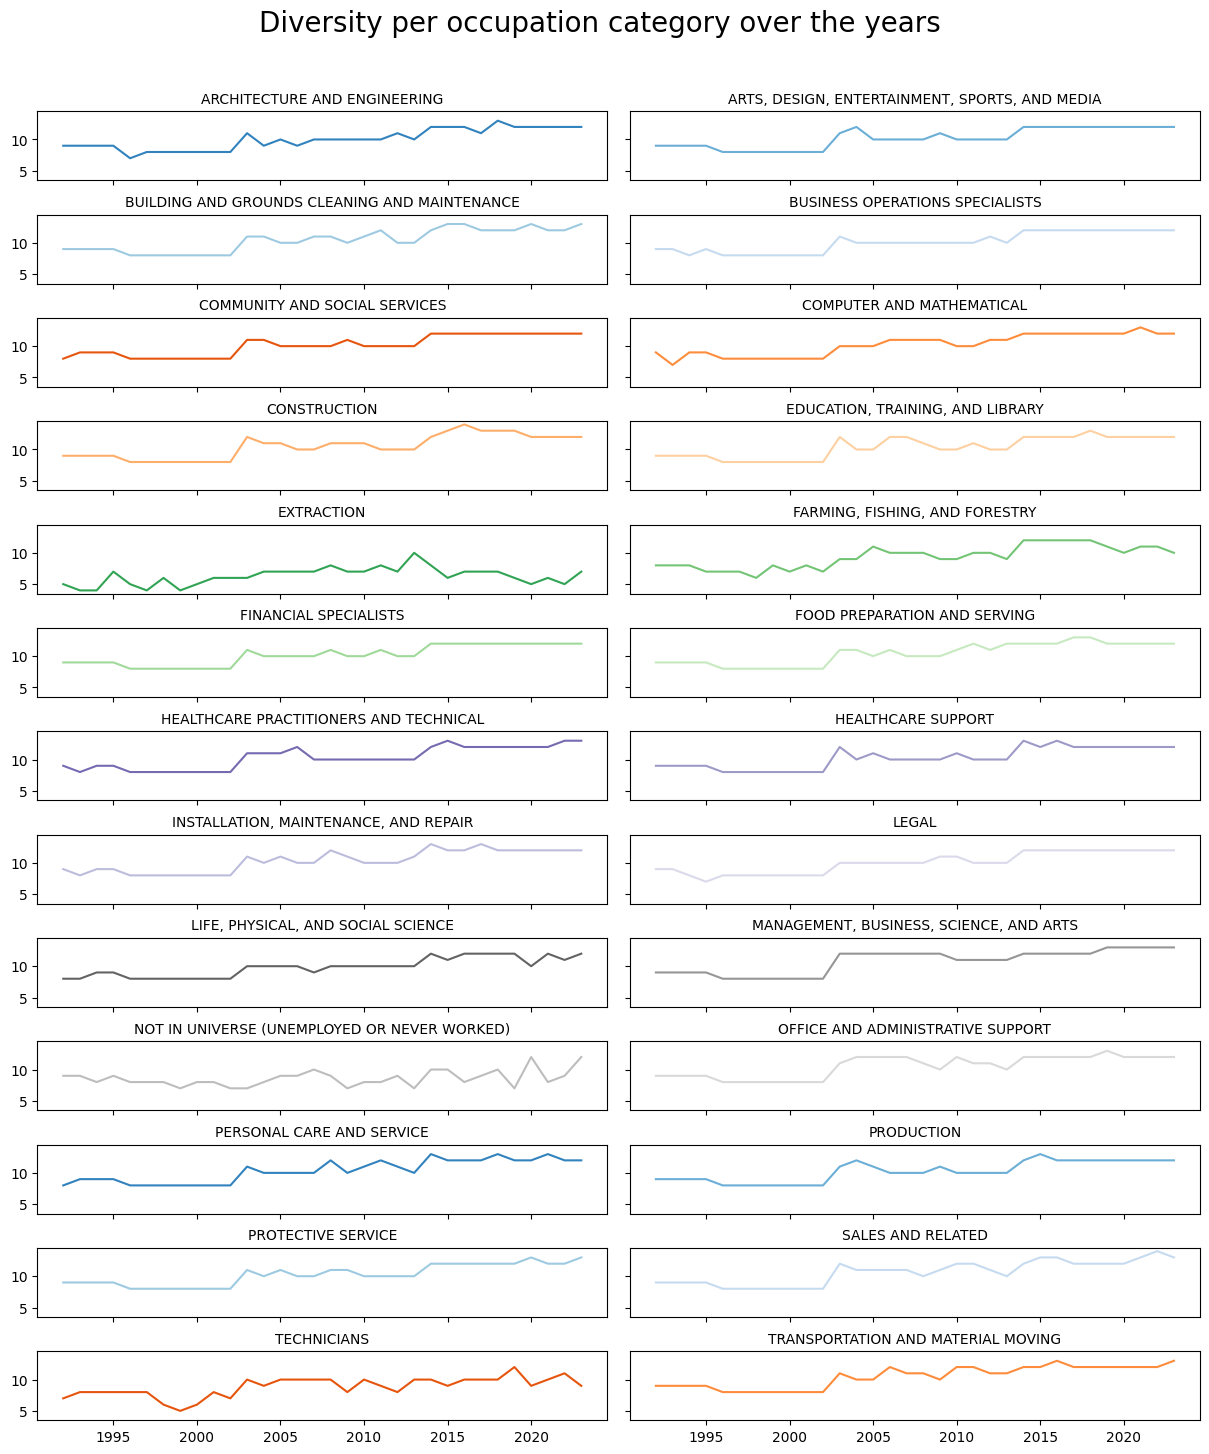

In [39]:
grouped_df = race_occ_df.groupby(['occ_category', 'race_title', 'YEAR']).size().reset_index(name='count')

fig, axs = plt.subplots(13,2, figsize=(15, 17), sharex=True, sharey=True)
axs = list(chain(*axs))
fig.subplots_adjust(hspace= 0.5, wspace=0.04)
colors = cycle(plt.cm.tab20c.colors)
for (occupation_category, group_df), ax in zip(grouped_df.groupby('occ_category'), axs):
    # Pivot the DataFrame to have 'race_title' as columns and 'count' as values
    pivot_df = group_df.pivot_table(index=['YEAR'], columns='race_title', values='count', fill_value=0)

    pivot_df['nr_races'] = (pivot_df != 0.0).sum(1)
    pivot_df = pivot_df.reset_index()

    c = next(colors)
    ax.plot(pivot_df['YEAR'], pivot_df['nr_races'], color=c)
    ax.set_title(occupation_category, fontsize =10)

fig.suptitle('Diversity per occupation category over the years',ha='center', fontsize=20, y = 0.94)

In [40]:
df = race_occ_df[['YEAR', 'occ_category', 'race_code']]
pivot_df = df.pivot_table(index='occ_category', columns='YEAR', aggfunc=lambda x: len(set(x)))
pivot_df['mean'] = pivot_df.mean(axis=1)
pivot_df['sd'] = pivot_df.std(axis=1)
display(pivot_df)

race_code                      \
YEAR                                                1992 1993 1994 1995 1996   
occ_category                                                                   
ARCHITECTURE AND ENGINEERING                           9    9    9    9    7   
ARTS, DESIGN, ENTERTAINMENT, SPORTS, AND MEDIA         9    9    9    9    8   
BUILDING AND GROUNDS CLEANING AND MAINTENANCE          9    9    9    9    8   
BUSINESS OPERATIONS SPECIALISTS                        9    9    8    9    8   
COMMUNITY AND SOCIAL SERVICES                          8    9    9    9    8   
COMPUTER AND MATHEMATICAL                              9    7    9    9    8   
CONSTRUCTION                                           9    9    9    9    8   
EDUCATION, TRAINING, AND LIBRARY                       9    9    9    9    8   
EXTRACTION                                             5    4    4    7    5   
FARMING, FISHING, AND FORESTRY                         8    8    8    7    7   
FINANCIAL SPECIALISTS                                  9    9    9    9    8   
FOOD PREPARATION AND SERVING                           9    9    9    9    8   
HEALTHCARE PRACTITIONERS AND TECHNICAL                 9    8    9    9    8   
HEALTHCARE SUPPORT                                     9    9    9    9    8   
INSTALLATION, MAINTENANCE, AND REPAIR                  9    8    9    9    8   
LEGAL                                                  9    9    8    7    8   
LIFE, PHYSICAL, AND SOCIAL SCIENCE                     8    8    9    9    8   
MANAGEMENT, BUSINESS, SCIENCE, AND ARTS                9    9    9    9    8   
NOT IN UNIVERSE (UNEMPLOYED OR NEVER WORKED)           9    9    8    9    8   
OFFICE AND ADMINISTRATIVE SUPPORT                      9    9    9    9    8   
PERSONAL CARE AND SERVICE                              8    9    9    9    8   
PRODUCTION                                             9    9    9    9    8   
PROTECTIVE SERVICE                                     9    9    9    9    8   
SALES AND RELATED                                      9    9    9    9    8   
TECHNICIANS                                            7    8    8    8    8   
TRANSPORTATION AND MATERIAL MOVING                     9    9    9    9    8   

                                                                         ...  \
YEAR                                           1997 1998 1999 2000 2001  ...   
occ_category                                                             ...   
ARCHITECTURE AND ENGINEERING                      8    8    8    8    8  ...   
ARTS, DESIGN, ENTERTAINMENT, SPORTS, AND MEDIA    8    8    8    8    8  ...   
BUILDING AND GROUNDS CLEANING AND MAINTENANCE     8    8    8    8    8  ...   
BUSINESS OPERATIONS SPECIALISTS                   8    8    8    8    8  ...   
COMMUNITY AND SOCIAL SERVICES                     8    8    8    8    8  ...   
COMPUTER AND MATHEMATICAL                         8    8    8    8    8  ...   
CONSTRUCTION                                      8    8    8    8    8  ...   
EDUCATION, TRAINING, AND LIBRARY                  8    8    8    8    8  ...   
EXTRACTION                                        4    6    4    5    6  ...   
FARMING, FISHING, AND FORESTRY                    7    6    8    7    8  ...   
FINANCIAL SPECIALISTS                             8    8    8    8    8  ...   
FOOD PREPARATION AND SERVING                      8    8    8    8    8  ...   
HEALTHCARE PRACTITIONERS AND TECHNICAL            8    8    8    8    8  ...   
HEALTHCARE SUPPORT                                8    8    8    8    8  ...   
INSTALLATION, MAINTENANCE, AND REPAIR             8    8    8    8    8  ...   
LEGAL                                             8    8    8    8    8  ...   
LIFE, PHYSICAL, AND SOCIAL SCIENCE                8    8    8    8    8  ...   
MANAGEMENT, BUSINESS, SCIENCE, AND ARTS           8    8    8    8    8  ...   
NOT IN UNIVERSE (UNEMPLOYED OR NEVER WORKED)  

## Can job transitions from not so diverse job categories to more diverse ones be observed? (Is there a trend to become more diverse? Is there a specific timespan when this started/ was most intense?)

In [41]:
data_df = pd.read_csv(data_path, sep=';')

In [42]:
with open('occ_2010_cat.json', 'r') as file:
    occ_2010_cat = json.load(file)

category_df = pd.DataFrame([(code, category) for category, codes in occ_2010_cat.items() for code in codes],
                           columns=['OCC2010', 'Category'])

In [43]:
race_occ_df = pd.DataFrame()
race_occ_df['YEAR'] = data_df['YEAR']
race_occ_df['race_code'] = data_df['RACE']
race_occ_df['ASECWT'] = data_df['ASECWT']
race_occ_df['occ_code'] = data_df['OCC2010']
race_occ_df['occ_category'] = data_df['Category']
race_occ_df['OCCLY'] = data_df['OCC10LY']

In [44]:
race_occ_df = pd.merge(race_occ_df, category_df, left_on='OCCLY', right_on = 'OCC2010')
race_occ_df = race_occ_df.rename(columns = {'Category': 'occ_category_LY'})
race_occ_df.drop('OCC2010', inplace=True, axis=1)

### Occupation transition per race
The results show that across all races it is more common to keep their current job. Only few occurences where more people transitioned to a different job than staying in the same could be observed: 
* American Indian-Asian
* White-Black Hawaiian/Pacific Islander
* White American Indian Hawaiian/Pacific Islander
* American Indian Hawaiian/Pacific Islander

In [45]:
same_occly = race_occ_df[race_occ_df['occ_code'] == race_occ_df['OCCLY']]

In [46]:
pivot_df_same = same_occly.pivot_table(index='YEAR', columns='race_code', aggfunc='size', fill_value=0)
pivot_df_same.columns.name = None
pivot_df_same = pivot_df_same.reset_index()

In [47]:
for year, df in same_occly.groupby('YEAR'):
    print(year, ': ', len(df['race_code'].unique()))
    print('Nr of jobs categories with no transition: ', len(df['occ_category'].unique()))
    print(df['occ_category'].unique())

1992 :  9
Nr of jobs categories with no transition:  25
['TRANSPORTATION AND MATERIAL MOVING' 'CONSTRUCTION'
 'LIFE, PHYSICAL, AND SOCIAL SCIENCE'
 'BUILDING AND GROUNDS CLEANING AND MAINTENANCE' 'PROTECTIVE SERVICE'
 'FOOD PREPARATION AND SERVING' 'SALES AND RELATED'
 'MANAGEMENT, BUSINESS, SCIENCE, AND ARTS' 'COMMUNITY AND SOCIAL SERVICES'
 'EDUCATION, TRAINING, AND LIBRARY' 'FINANCIAL SPECIALISTS'
 'HEALTHCARE PRACTITIONERS AND TECHNICAL' 'PERSONAL CARE AND SERVICE'
 'PRODUCTION' 'OFFICE AND ADMINISTRATIVE SUPPORT'
 'FARMING, FISHING, AND FORESTRY' 'HEALTHCARE SUPPORT'
 'INSTALLATION, MAINTENANCE, AND REPAIR' 'BUSINESS OPERATIONS SPECIALISTS'
 'ARCHITECTURE AND ENGINEERING' 'TECHNICIANS' 'LEGAL'
 'ARTS, DESIGN, ENTERTAINMENT, SPORTS, AND MEDIA' 'EXTRACTION'
 'COMPUTER AND MATHEMATICAL']
1993 :  9
Nr of jobs categories with no transition:  25
['TRANSPORTATION AND MATERIAL MOVING' 'CONSTRUCTION'
 'LIFE, PHYSICAL, AND SOCIAL SCIENCE'
 'BUILDING AND GROUNDS CLEANING AND MAINTENANCE' 'PR

In [48]:
diff_occly = race_occ_df[race_occ_df['occ_code'] != race_occ_df['OCCLY']]

In [49]:
pivot_diff = diff_occly.pivot_table(index='YEAR', columns='race_code', aggfunc='size', fill_value=0)
pivot_diff.columns.name = None
pivot_diff = pivot_diff.reset_index()

In [50]:
for year, df in diff_occly.groupby('YEAR'):
    print(year, ': ', len(df['race_code'].unique()))
    print('Nr of jobs categories with transition: ', len(df['occ_category'].unique()))
    print(df['occ_category'].unique())

1992 :  9
Nr of jobs categories with transition:  26
['FOOD PREPARATION AND SERVING' 'PERSONAL CARE AND SERVICE' 'TECHNICIANS'
 'SALES AND RELATED' 'TRANSPORTATION AND MATERIAL MOVING' 'PRODUCTION'
 'OFFICE AND ADMINISTRATIVE SUPPORT' 'FINANCIAL SPECIALISTS' 'LEGAL'
 'HEALTHCARE SUPPORT' 'BUILDING AND GROUNDS CLEANING AND MAINTENANCE'
 'BUSINESS OPERATIONS SPECIALISTS'
 'MANAGEMENT, BUSINESS, SCIENCE, AND ARTS'
 'INSTALLATION, MAINTENANCE, AND REPAIR'
 'LIFE, PHYSICAL, AND SOCIAL SCIENCE' 'PROTECTIVE SERVICE' 'CONSTRUCTION'
 'FARMING, FISHING, AND FORESTRY'
 'ARTS, DESIGN, ENTERTAINMENT, SPORTS, AND MEDIA'
 'EDUCATION, TRAINING, AND LIBRARY'
 'HEALTHCARE PRACTITIONERS AND TECHNICAL'
 'NOT IN UNIVERSE (UNEMPLOYED OR NEVER WORKED)'
 'COMPUTER AND MATHEMATICAL' 'ARCHITECTURE AND ENGINEERING' 'EXTRACTION'
 'COMMUNITY AND SOCIAL SERVICES']
1993 :  9
Nr of jobs categories with transition:  26
['COMMUNITY AND SOCIAL SERVICES' 'TRANSPORTATION AND MATERIAL MOVING'
 'BUILDING AND GROUNDS CLEANIN

In [53]:
same = ['TRANSPORTATION AND MATERIAL MOVING','CONSTRUCTION', 'LIFE, PHYSICAL, AND SOCIAL SCIENCE',
 'BUILDING AND GROUNDS CLEANING AND MAINTENANCE','PROTECTIVE SERVICE', 'FOOD PREPARATION AND SERVING', 'SALES AND RELATED',
 'MANAGEMENT, BUSINESS, SCIENCE, AND ARTS', 'COMMUNITY AND SOCIAL SERVICES',
 'EDUCATION, TRAINING, AND LIBRARY', 'FINANCIAL SPECIALISTS',
 'HEALTHCARE PRACTITIONERS AND TECHNICAL', 'PERSONAL CARE AND SERVICE',
 'PRODUCTION', 'OFFICE AND ADMINISTRATIVE SUPPORT',
 'FARMING, FISHING, AND FORESTRY', 'HEALTHCARE SUPPORT',
 'INSTALLATION, MAINTENANCE, AND REPAIR', 'BUSINESS OPERATIONS SPECIALISTS',
 'ARCHITECTURE AND ENGINEERING', 'TECHNICIANS', 'LEGAL',
 'ARTS, DESIGN, ENTERTAINMENT, SPORTS, AND MEDIA', 'EXTRACTION',
 'COMPUTER AND MATHEMATICAL']

diff = ['BUILDING AND GROUNDS CLEANING AND MAINTENANCE',
 'TRANSPORTATION AND MATERIAL MOVING', 'OFFICE AND ADMINISTRATIVE SUPPORT',
 'NOT IN UNIVERSE (UNEMPLOYED OR NEVER WORKED)', 'CONSTRUCTION',
 'PRODUCTION', 'SALES AND RELATED', 'FOOD PREPARATION AND SERVING',
 'MANAGEMENT, BUSINESS, SCIENCE, AND ARTS',
 'INSTALLATION, MAINTENANCE, AND REPAIR', 'COMMUNITY AND SOCIAL SERVICES',
 'TECHNICIANS', 'PROTECTIVE SERVICE',
 'ARTS, DESIGN, ENTERTAINMENT, SPORTS, AND MEDIA',
 'BUSINESS OPERATIONS SPECIALISTS', 'COMPUTER AND MATHEMATICAL',
 'FARMING, FISHING, AND FORESTRY', 'EDUCATION, TRAINING, AND LIBRARY',
 'HEALTHCARE PRACTITIONERS AND TECHNICAL',
 'LIFE, PHYSICAL, AND SOCIAL SCIENCE', 'PERSONAL CARE AND SERVICE', 'LEGAL',
 'ARCHITECTURE AND ENGINEERING', 'FINANCIAL SPECIALISTS',
 'HEALTHCARE SUPPORT', 'EXTRACTION']

set(same).symmetric_difference(set(diff))

{'NOT IN UNIVERSE (UNEMPLOYED OR NEVER WORKED)'}

In [54]:
melted_df_diff = pd.melt(pivot_diff, id_vars=['YEAR'], var_name='race_code', value_name='value')
melted_df_same = pd.melt(pivot_df_same, id_vars=['YEAR'], var_name='race_code', value_name='value')

melted_df_same

YEAR race_code  value
0    1992       100  47558
1    1993       100  46754
2    1994       100  45474
3    1995       100  44690
4    1996       100  38883
..    ...       ...    ...
507  2019       960   2708
508  2020       960   2335
509  2021       960   2326
510  2022       960   2565
511  2023       960   2516

[512 rows x 3 columns]

In [55]:
melted_df_same['race_code'].unique() == melted_df_diff['race_code'].unique()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [56]:
len(melted_df_diff['race_code'].unique())

16

The plot shows a per race comparison of how many people transitioned to another occupation  within the last year or not. The trend shows, that people mostly keep their occupation. Some races could not be chosen in earlier years, which explains the continuous zeros and the resulting straight lines for some.

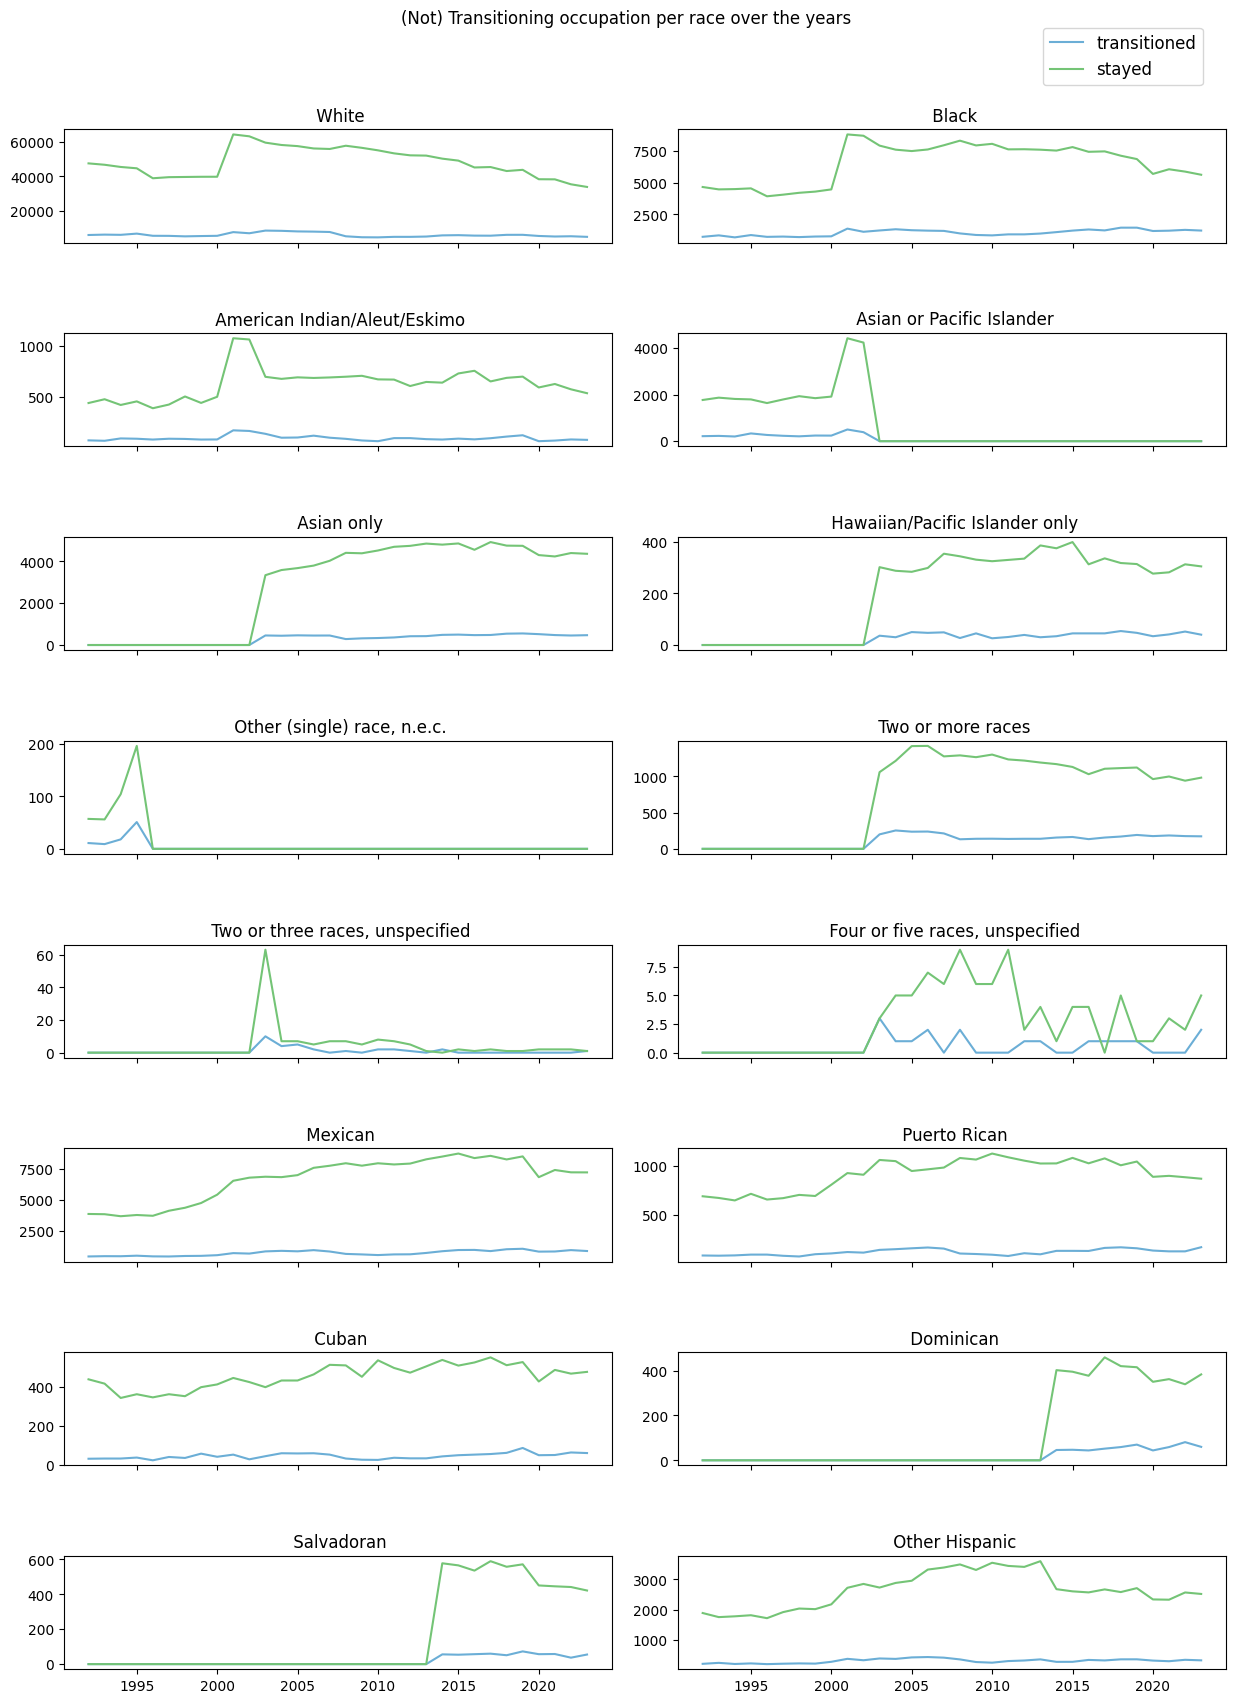

In [84]:
fig, axs = plt.subplots(8, 2, figsize=(15, 20), sharex = True)
colors_ = plt.colormaps['tab20c']

axs = list(chain(*axs))
fig.subplots_adjust(hspace= 0.8, wspace=0.12)

# Loop through unique race codes
sorted_race_codes = np.sort(melted_df_diff['race_code'].unique())
for race_code, ax in zip(sorted_race_codes, axs):

    ax.set_title(race_codes_df[race_codes_df['race_code'] == race_code]['race_title'].item())

    race_data_diff = melted_df_diff[melted_df_diff['race_code'] == race_code]
    ax.plot(race_data_diff['YEAR'], race_data_diff['value'], label = 'transitioned', color=colors_.colors[1])

    race_data_same = melted_df_same[melted_df_same['race_code'] == race_code]
    ax.plot(race_data_same['YEAR'], race_data_same['value'], label = 'stayed', color=colors_.colors[9])

fig.suptitle('(Not) Transitioning occupation per race over the years', y=0.94)
fig.legend(*[*zip(*{l:h for h,l in zip(*ax.get_legend_handles_labels())}.items())][::-1], loc =  'upper right', fontsize = 12, bbox_to_anchor=(0.89, 0.935))

plt.show()

In [85]:
def compare_race_transitions(race_title: str = None, code: int = None):
    if race_title != None and code == None:
        race_code = race_codes_df[race_codes_df['race_title'] == race_title]['race_code'].item()
    else:
        race_code = code

    same = melted_df_same[melted_df_same['race_code'] == race_code]
    diff = melted_df_diff[melted_df_diff['race_code'] == race_code]
    comp = same.merge(diff, on = 'YEAR')
    comp.drop(['race_code_y', 'race_code_x'], axis=1, inplace = True)
    comp.rename(columns = {'value_x': 'stayed_count', 'value_y': 'transitioned_count'}, inplace = True)

    print(race_code, race_title)
    display(comp)

In [86]:
compare_race_transitions(" White")

100  White


YEAR  stayed_count  transitioned_count
0   1992         47558                5800
1   1993         46754                6021
2   1994         45474                5893
3   1995         44690                6605
4   1996         38883                5336
5   1997         39520                5299
6   1998         39635                5007
7   1999         39744                5184
8   2000         39769                5322
9   2001         64442                7479
10  2002         63339                6813
11  2003         59650                8369
12  2004         58284                8229
13  2005         57628                7887
14  2006         56260                7771
15  2007         55959                7554
16  2008         57848                5043
17  2009         56625                4486
18  2010         55164                4418
19  2011         53402                4722
20  2012         52251                4716
21  2013         52095                4896
22  2014         50316                5581
23  2015         49170                5704
24  2016         45176                5439
25  2017         45421                5393
26  2018         43100                5895
27  2019         43799                5908
28  2020         38317                5237
29  2021         38250                4917
30  2022         35365                5068
31  2023         33822                4722

### Weighed comparison of occupation & occupation category transitions per race

In [88]:
all_combinations = pd.DataFrame(list(product(race_occ_df['race_code'].unique(), range(1992, 2024))), columns=['race_code', 'YEAR'])

In [90]:
# kept previous job
summed_df_same = same_occly.groupby(['YEAR', 'race_code'])['ASECWT'].sum().reset_index()
summed_df_same.rename({'ASECWT': 'stayed_weighed'}, axis=1, inplace = True)

# changed job in previous year
summed_df_diff = diff_occly.groupby(['YEAR', 'race_code'])['ASECWT'].sum().reset_index()
summed_df_diff.rename({'ASECWT': 'transitioned_weighed'}, axis=1, inplace = True)

trans_vs_stayed = all_combinations.merge(summed_df_diff, on = ['YEAR', 'race_code'], how = 'left')
trans_vs_stayed = trans_vs_stayed.merge(summed_df_same, on = ['YEAR', 'race_code'], how = 'left')

In [91]:
# of those who changed jobs, how many stayed in same category?
# ! Not all races stay in the same category, e.g. 816
same_category = diff_occly[diff_occly['occ_category'] == diff_occly['occ_category_LY']]
same_category = same_category.groupby(['YEAR', 'race_code'])['ASECWT'].sum().reset_index()
same_category.rename({'ASECWT': 'same_occ_category'}, axis = 1, inplace = True)

# of those who changed jobs, how many switched category?
# ! Not all races switch to a different category
diff_category = diff_occly[diff_occly['occ_category'] != diff_occly['occ_category_LY']]
diff_category = diff_category.groupby(['YEAR', 'race_code'])['ASECWT'].sum().reset_index()
diff_category.rename({'ASECWT': 'diff_occ_category'}, axis = 1, inplace = True)

trans_vs_stayed = trans_vs_stayed.merge(same_category, on = ['YEAR', 'race_code'], how = 'left')
trans_vs_stayed = trans_vs_stayed.merge(diff_category, on = ['YEAR', 'race_code'], how='left')

NaN values represent that no person identifying as a specific race in that year switched to a different occupation category or stayed in the same category. Hence, those values can be replaced with 0.

In [92]:
trans_vs_stayed.isnull().sum()

race_code                 0
YEAR                      0
transitioned_weighed    168
stayed_weighed          150
same_occ_category       178
diff_occ_category       174
dtype: int64

In [93]:
trans_vs_stayed.fillna(0, inplace=True)

In [94]:
trans_vs_stayed['race_code'].unique()

array([100, 920, 930, 200, 650, 300, 960, 910, 651, 800, 652, 950, 940,
       700, 820, 830], dtype=int64)

Asian or Pacific Islander only has data up until 2002. To make plotting a comparison possible, fill the rest of the years with 0

In [96]:
# 650 = Asian or Pacific Islander
trans_vs_stayed[trans_vs_stayed['race_code'] == 650]['YEAR']

128    1992
129    1993
130    1994
131    1995
132    1996
133    1997
134    1998
135    1999
136    2000
137    2001
138    2002
139    2003
140    2004
141    2005
142    2006
143    2007
144    2008
145    2009
146    2010
147    2011
148    2012
149    2013
150    2014
151    2015
152    2016
153    2017
154    2018
155    2019
156    2020
157    2021
158    2022
159    2023
Name: YEAR, dtype: int64

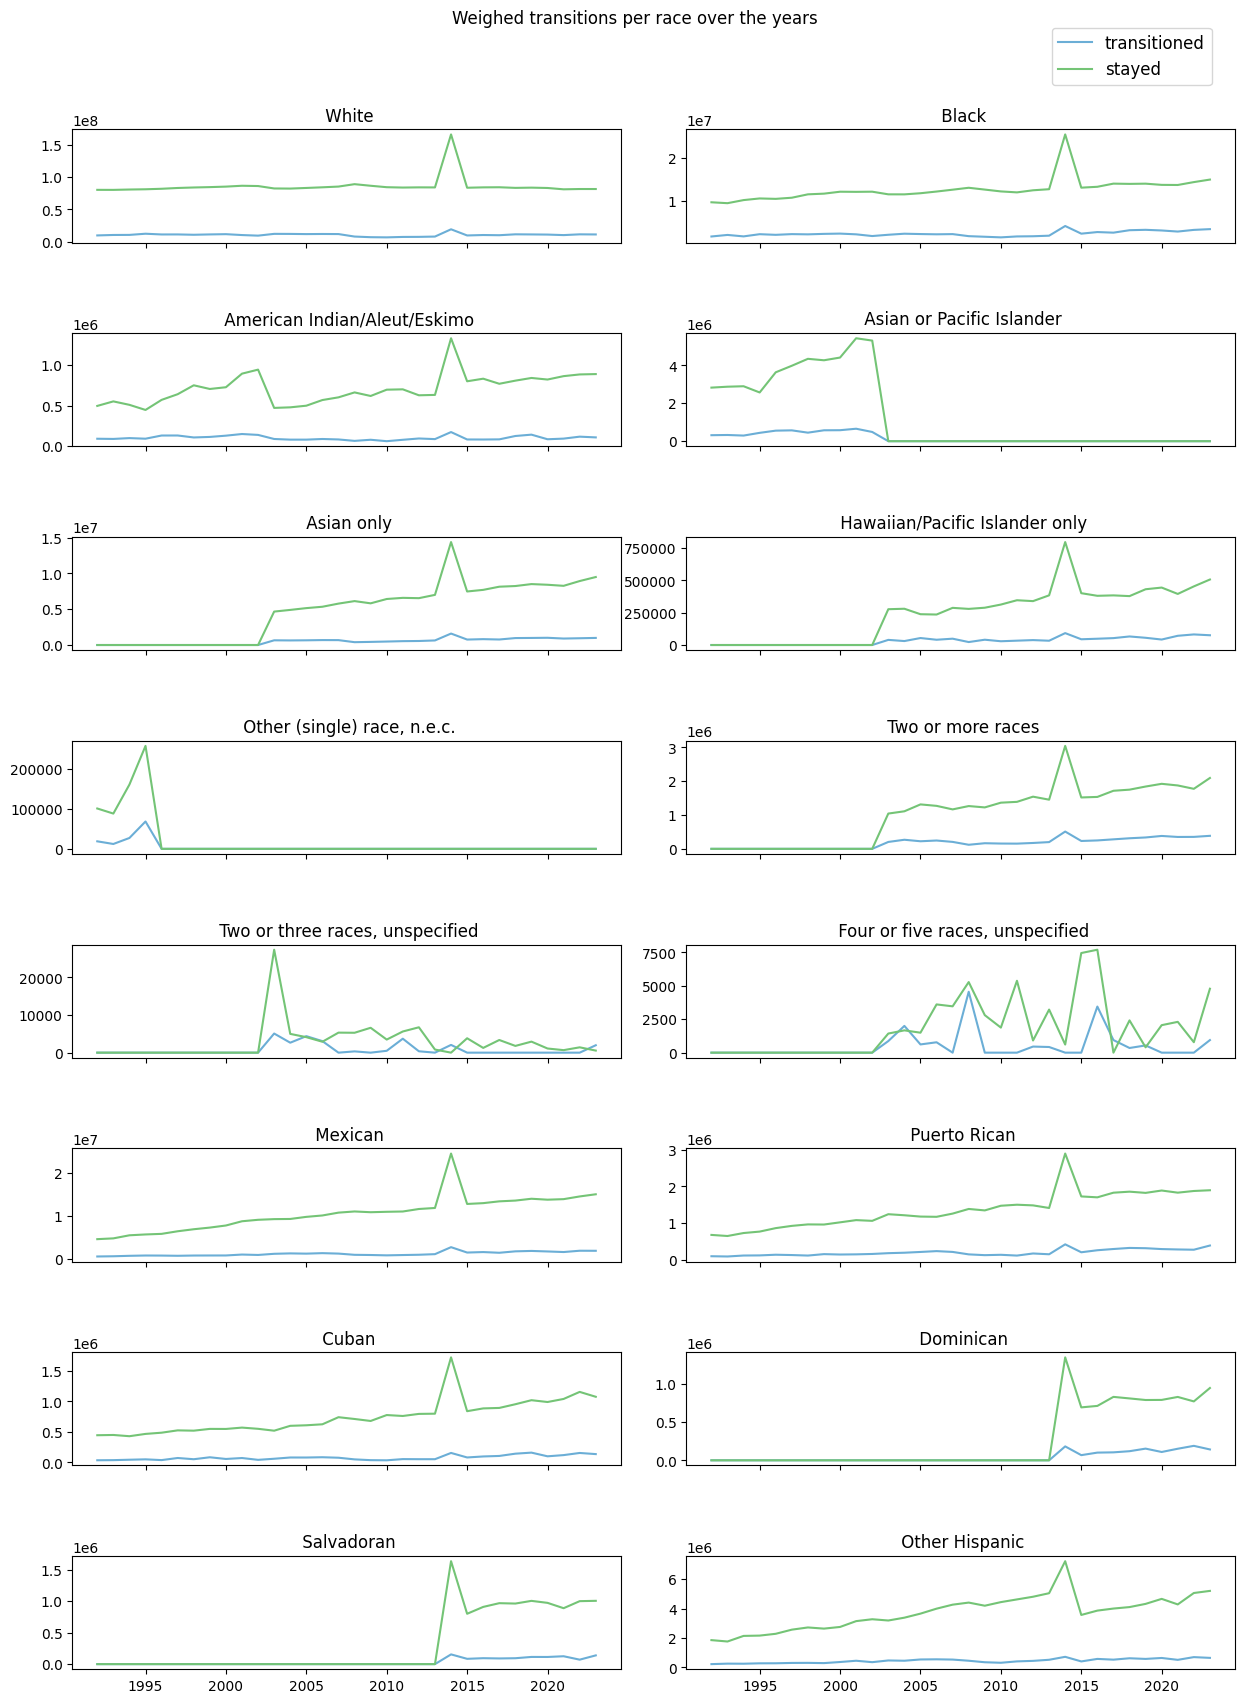

In [99]:
fig, axs = plt.subplots(8, 2, figsize=(15, 20), sharex = True)
colors_ = plt.colormaps['tab20c']


axs = list(chain(*axs))
fig.subplots_adjust(hspace= 0.8, wspace=0.12)

# Loop through unique race codes
sorted_race_codes = np.sort(trans_vs_stayed['race_code'].unique())
for race_code, ax in zip(sorted_race_codes, axs):
    ax.set_title(race_codes_df[race_codes_df['race_code'] == race_code]['race_title'].item())

    race_data = trans_vs_stayed[trans_vs_stayed['race_code'] == race_code]
    ax.plot(race_data['YEAR'], race_data['transitioned_weighed'], label = 'transitioned', color=colors_.colors[1])
    ax.plot(race_data['YEAR'], race_data['stayed_weighed'], label = 'stayed', color=colors_.colors[9])

fig.suptitle('Weighed transitions per race over the years', y=0.94)
fig.legend(*[*zip(*{l:h for h,l in zip(*ax.get_legend_handles_labels())}.items())][::-1], loc =  'upper right', fontsize = 12, bbox_to_anchor=(0.89, 0.935))

plt.show()

Of those who switched their job in the previous year, how many stayed in the same/transitioned to a different occupation category?

threshold, to not include all race categories
categorize race codes (two or more categories includes more races)

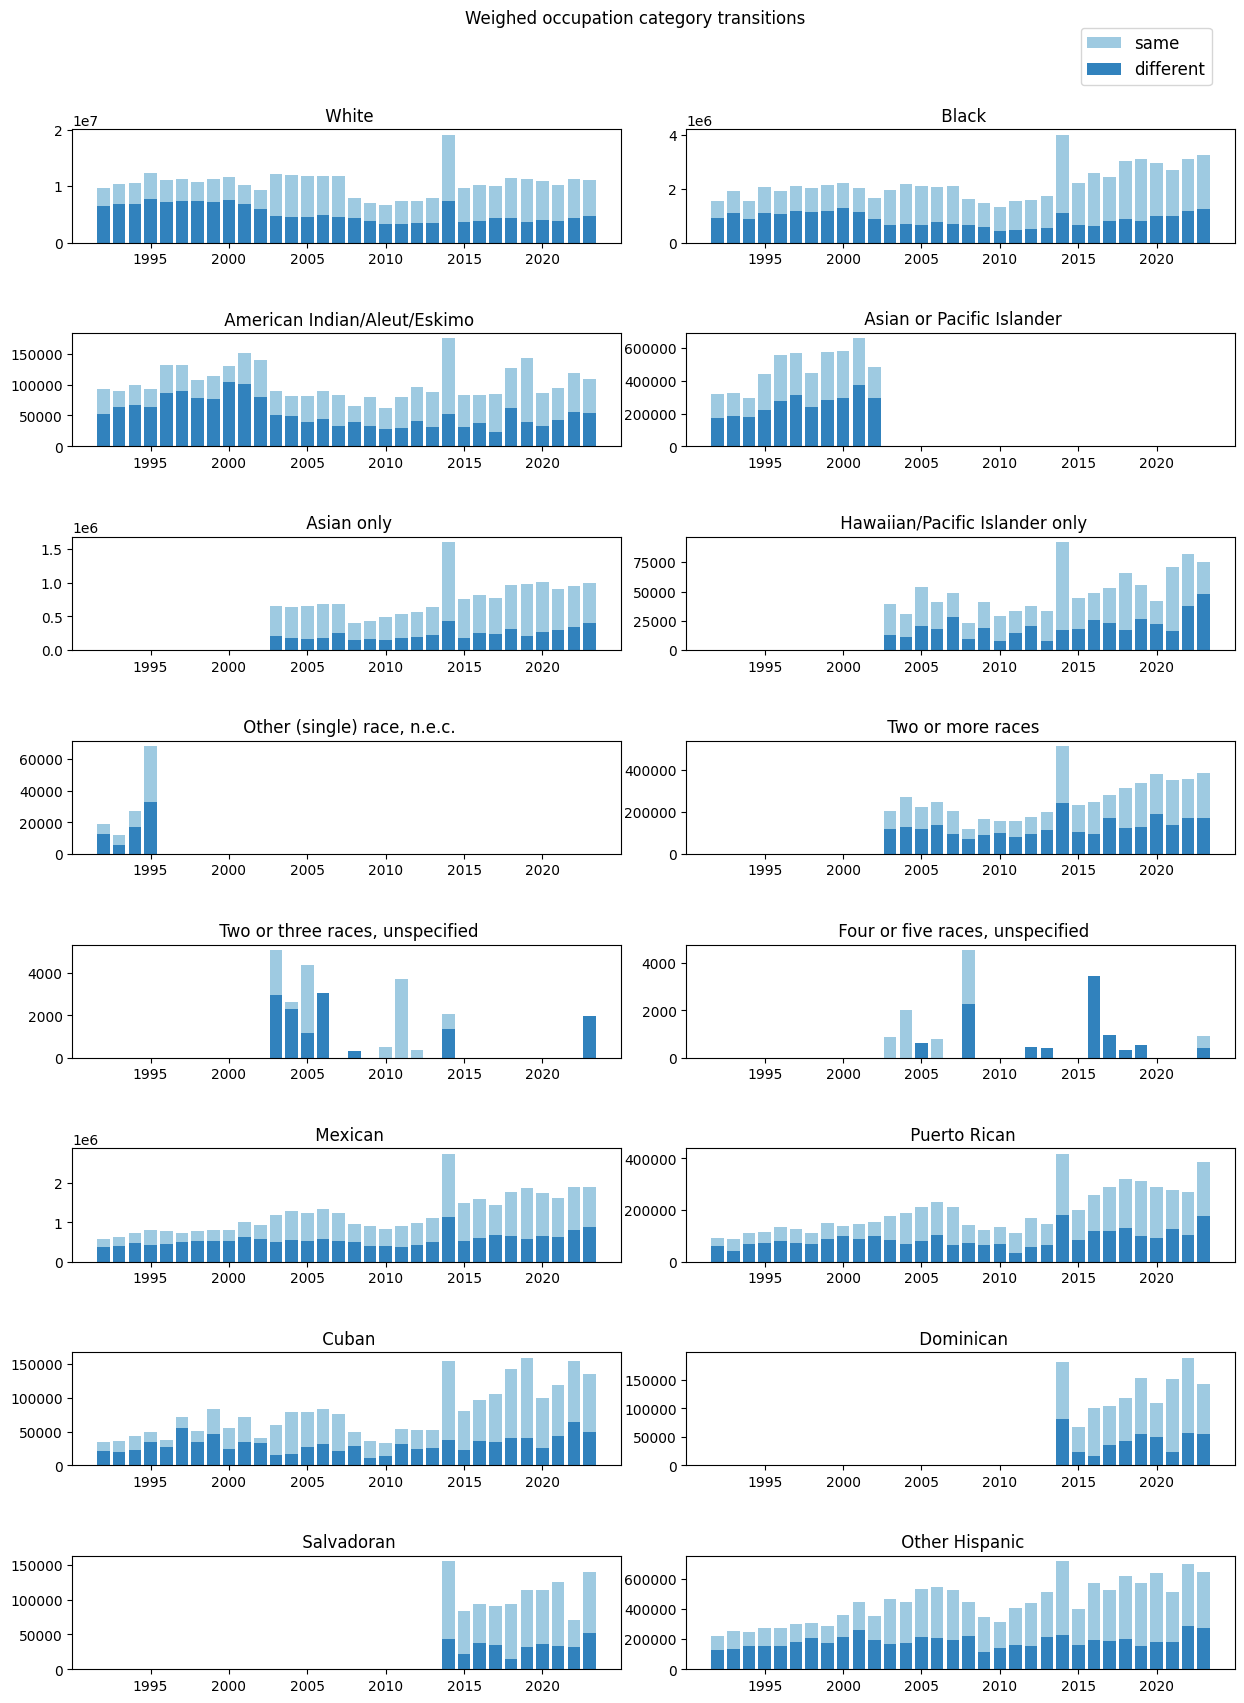

In [102]:
width = 0.35  # the width of the bars
colors_ = plt.colormaps['tab20c']

fig, axs = plt.subplots(8, 2,  figsize=(15, 20))
axs = list(chain(*axs))
fig.subplots_adjust(hspace= 0.8, wspace=0.12)

sorted_race_codes = np.sort(trans_vs_stayed['race_code'].unique())
for race_code, ax in zip(sorted_race_codes, axs):
    df = trans_vs_stayed[trans_vs_stayed['race_code'] == race_code]
    ax.set_title(race_codes_df[race_codes_df['race_code'] == race_code]['race_title'].item())

    ax.bar(df['YEAR'], df["same_occ_category"]+df["diff_occ_category"], label='same', color=colors_.colors[2]) 
    ax.bar(df["YEAR"], df["diff_occ_category"],  color=colors_.colors[0], label='different') 

fig.suptitle('Weighed occupation category transitions', y = 0.94)
fig.legend(*[*zip(*{l:h for h,l in zip(*ax.get_legend_handles_labels())}.items())][::-1], loc =  'upper right', fontsize = 12, bbox_to_anchor=(0.89, 0.935))

plt.show()

In [104]:
race_occ_df.loc[(race_occ_df['occ_category'] != race_occ_df['occ_category_LY']) & 
                (race_occ_df['race_code'] == 800) &
                (race_occ_df['occ_code'] != race_occ_df['OCCLY'])]

YEAR  race_code     ASECWT  occ_code  \
956      2007        800   958.3400      4220   
1207     2009        800  1473.7000      5120   
1706     2015        800   396.5100      8965   
11841    2021        800  1619.9587      4965   
11903    2005        800  1178.6300      9130   
...       ...        ...        ...       ...   
2542968  2018        800  1984.9000      7810   
2543377  2018        800   526.0500       150   
2544688  2023        800  2358.7900      4820   
2549630  2010        800   829.3600      5840   
2554254  2013        800  1354.1900      4760   

                                          occ_category  OCCLY  \
956      BUILDING AND GROUNDS CLEANING AND MAINTENANCE   9350   
1207                 OFFICE AND ADMINISTRATIVE SUPPORT   9100   
1706                                        PRODUCTION   9100   
11841                                SALES AND RELATED   6420   
11903               TRANSPORTATION AND MATERIAL MOVING   6420   
...                                                ...    ...   
2542968                                     PRODUCTION   6720   
2543377        MANAGEMENT, BUSINESS, SCIENCE, AND ARTS   1640   
2544688                              SALES AND RELATED   1240   
2549630              OFFICE AND ADMINISTRATIVE SUPPORT   7510   
2554254                              SALES AND RELATED   9420   

                               occ_category_LY  
956         TRANSPORTATION AND MATERIAL MOVING  
1207        TRANSPORTATION AND MATERIAL MOVING  
1706        TRANSPORTATION AND MATERIAL MOVING  
11841                             CONSTRUCTION  
11903                             CONSTRUCTION  
...                                        ...  
2542968                           CONSTRUCTION  
2543377     LIFE, PHYSICAL, AND SOCIAL SCIENCE  
2544688              COMPUTER AND MATHEMATICAL  
2549630  INSTALLATION, MAINTENANCE, AND REPAIR  
2554254     TRANSPORTATION AND MATERIAL MOVING  

[1802 rows x 7 columns]

In [105]:
race_occ_df.loc[(race_occ_df['race_code']==800) & (race_occ_df['YEAR'] == 2021)]

YEAR  race_code     ASECWT  occ_code  \
10971    2021        800  1750.6785      9100   
11841    2021        800  1619.9587      4965   
12193    2021        800  1564.0338      6600   
20784    2021        800   839.4569      6420   
20892    2021        800  1012.2174      6420   
...       ...        ...        ...       ...   
2545192  2021        800  1332.3716      1240   
2545193  2021        800   724.6952      1240   
2545279  2021        800  2846.2183      1240   
2545288  2021        800   513.0457      1240   
2558128  2021        800  2582.4720      3010   

                                   occ_category  OCCLY  \
10971        TRANSPORTATION AND MATERIAL MOVING   9100   
11841                         SALES AND RELATED   6420   
12193                              CONSTRUCTION   6420   
20784                              CONSTRUCTION   6420   
20892                              CONSTRUCTION   6420   
...                                         ...    ...   
2545192               COMPUTER AND MATHEMATICAL   1240   
2545193               COMPUTER AND MATHEMATICAL   1240   
2545279               COMPUTER AND MATHEMATICAL   1240   
2545288               COMPUTER AND MATHEMATICAL   1240   
2558128  HEALTHCARE PRACTITIONERS AND TECHNICAL   3010   

                                occ_category_LY  
10971        TRANSPORTATION AND MATERIAL MOVING  
11841                              CONSTRUCTION  
12193                              CONSTRUCTION  
20784                              CONSTRUCTION  
20892                              CONSTRUCTION  
...                                         ...  
2545192               COMPUTER AND MATHEMATICAL  
2545193               COMPUTER AND MATHEMATICAL  
2545279               COMPUTER AND MATHEMATICAL  
2545288               COMPUTER AND MATHEMATICAL  
2558128  HEALTHCARE PRACTITIONERS AND TECHNICAL  

[1185 rows x 7 columns]

### Other

In [109]:
race_occ_df[race_occ_df['race_code'] == 300]

YEAR  race_code     ASECWT  occ_code  \
10       1992        300   984.5500      9350   
406      2007        300   967.2500      9350   
411      2007        300   865.7000      9350   
449      2008        300   746.2900      9350   
1223     1994        300  2229.6900      9130   
...       ...        ...        ...       ...   
2558142  2021        300  1032.4221      3010   
2558319  1999        300   423.5700      3060   
2558512  2014        300  3026.5600      1610   
2558676  2003        300   747.0500      1700   
2559044  2020        300   600.3846      3200   

                                   occ_category  OCCLY  \
10           TRANSPORTATION AND MATERIAL MOVING   9350   
406          TRANSPORTATION AND MATERIAL MOVING   9350   
411          TRANSPORTATION AND MATERIAL MOVING   9350   
449          TRANSPORTATION AND MATERIAL MOVING   9350   
1223         TRANSPORTATION AND MATERIAL MOVING   9100   
...                                         ...    ...   
2558142  HEALTHCARE PRACTITIONERS AND TECHNICAL   3010   
2558319  HEALTHCARE PRACTITIONERS AND TECHNICAL   3010   
2558512      LIFE, PHYSICAL, AND SOCIAL SCIENCE   1700   
2558676      LIFE, PHYSICAL, AND SOCIAL SCIENCE   1700   
2559044  HEALTHCARE PRACTITIONERS AND TECHNICAL   3200   

                                occ_category_LY  
10           TRANSPORTATION AND MATERIAL MOVING  
406          TRANSPORTATION AND MATERIAL MOVING  
411          TRANSPORTATION AND MATERIAL MOVING  
449          TRANSPORTATION AND MATERIAL MOVING  
1223         TRANSPORTATION AND MATERIAL MOVING  
...                                         ...  
2558142  HEALTHCARE PRACTITIONERS AND TECHNICAL  
2558319  HEALTHCARE PRACTITIONERS AND TECHNICAL  
2558512      LIFE, PHYSICAL, AND SOCIAL SCIENCE  
2558676      LIFE, PHYSICAL, AND SOCIAL SCIENCE  
2559044  HEALTHCARE PRACTITIONERS AND TECHNICAL  

[23054 rows x 7 columns]